# 연습문제(2) 풀이

## 준비작업

### [1] 패키지 참조

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_excel, melt, DataFrame
from scipy.stats import normaltest, bartlett, levene, ttest_ind

# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import anova_oneway
from pingouin import anova
from pingouin import welch_anova

# 사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_gameshowell, pairwise_tukey

### [2] 그래프 초기화

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 9
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.unicode_minus"] = False

## 문제 1

### [1] 데이터 가져오기

In [3]:
origin = read_excel("https://data.hossam.kr/mldata/tree_weight.xlsx")
origin

,weight,group
0,4.17,A
1,5.58,A
2,5.18,A
3,6.11,A
4,4.50,A
5,4.61,A
6,5.17,A
7,4.53,A
8,5.33,A
9,5.14,A


### [2] 데이터 분포 확인

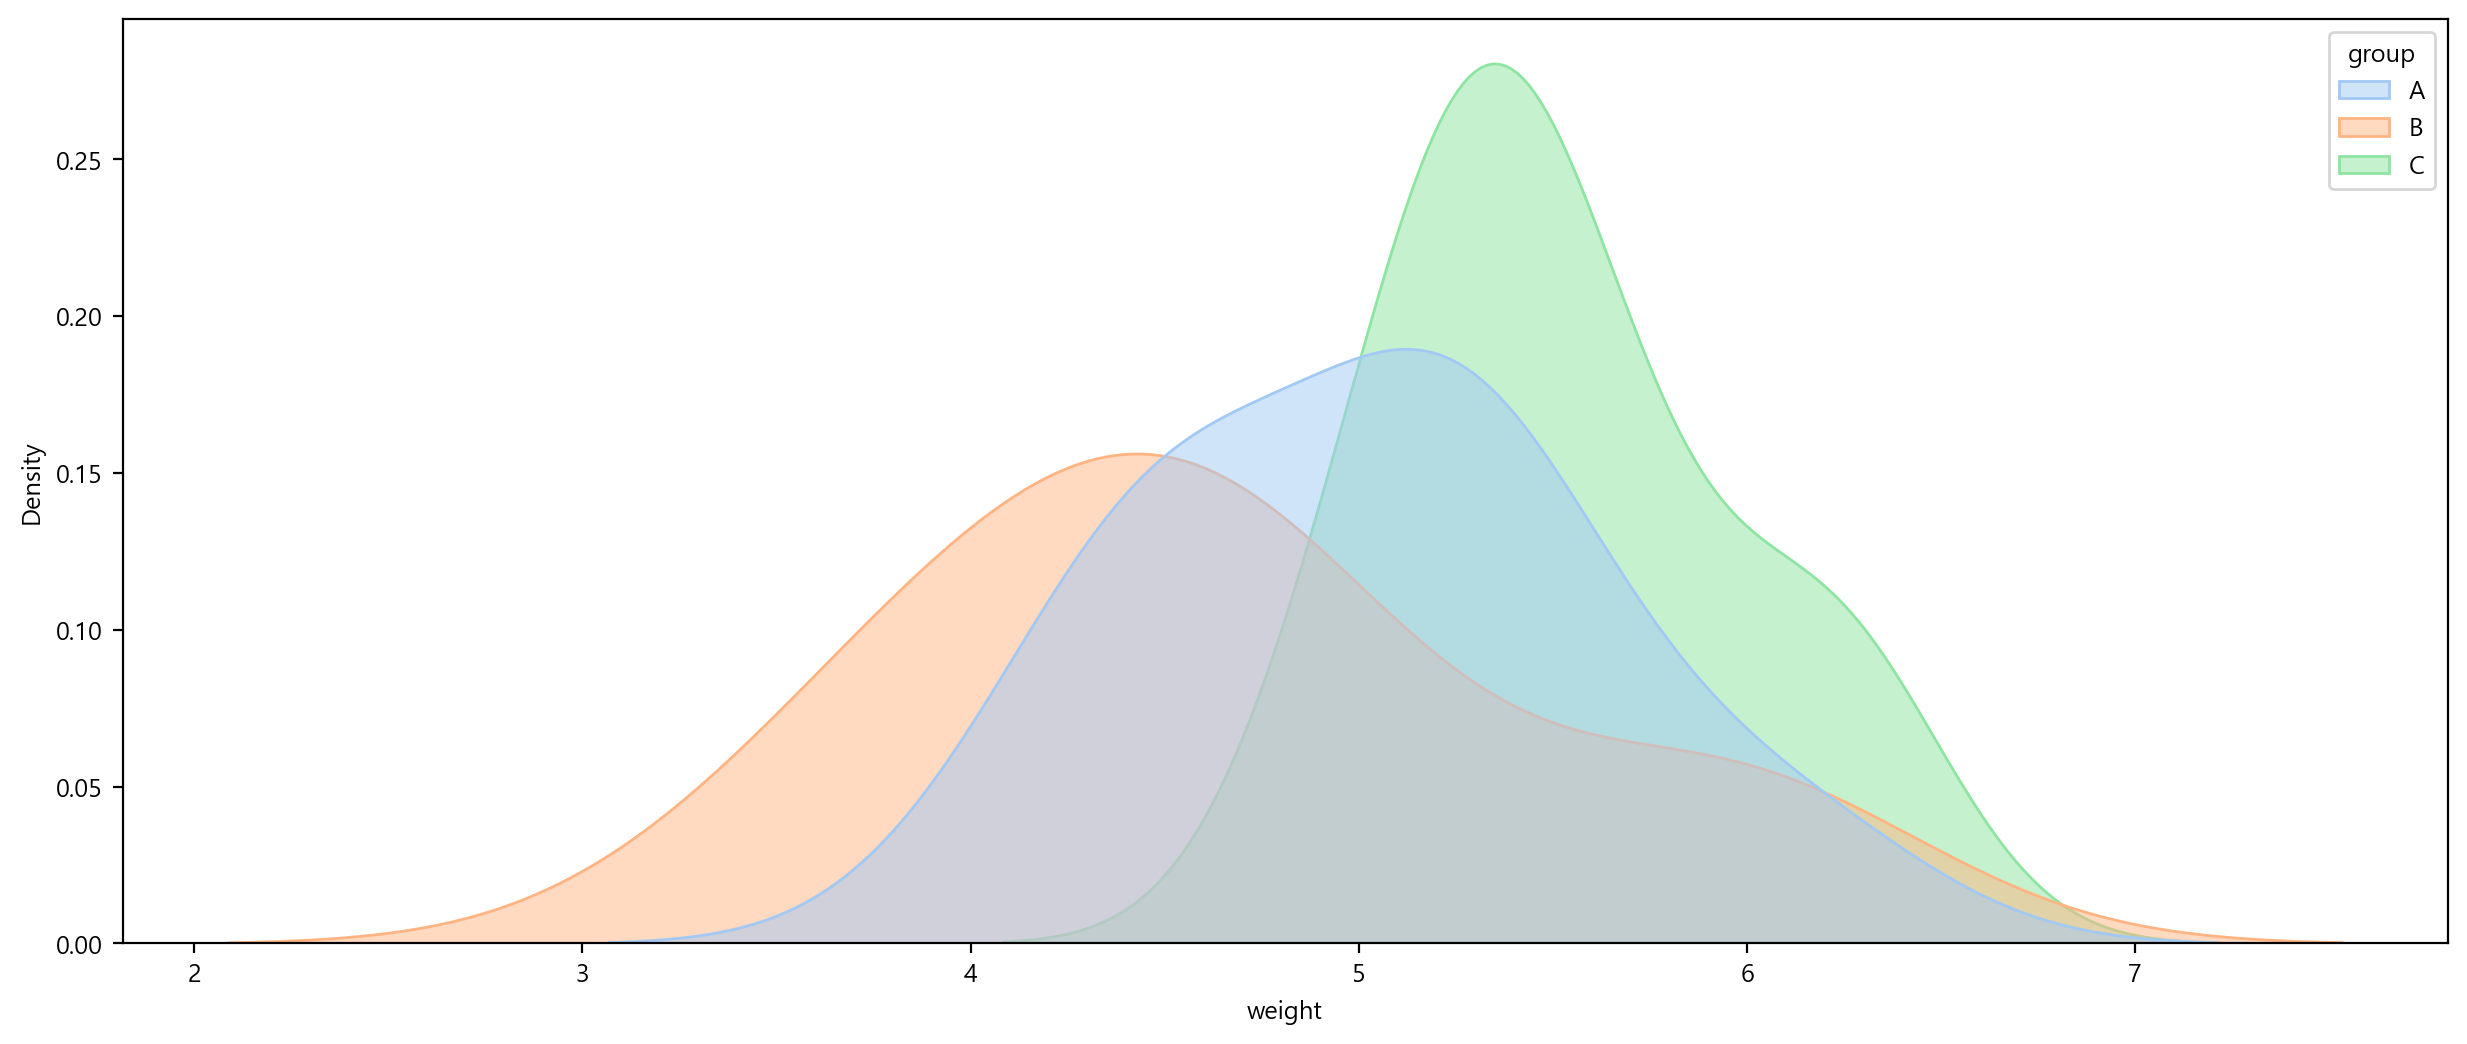

In [4]:
plt.figure()
sb.kdeplot(data=origin, x='weight', hue='group',
               fill=True, alpha=0.5, palette='pastel')
plt.show()
plt.close()

> 품종별로 데이터의 분포와 평균은 차이가 있는 것으로 보인다.

### [3] 정규성, 등분산성 확인

In [5]:
data = origin.copy()
xname = 'group'
yname = 'weight'

u1 = data[xname].unique()   # 명목형 변수의 값의 종류
equal_var_fields = []       # 등분산성 검정에 적용할 분할된 필드를 담을 리스트
normal_dist = True          # 정규성 확인 결과값
report = []                 # 최종 결과를 저장할 리스트

for i in u1:
    filtered_data = data[data[xname] == i][yname]
    equal_var_fields.append(filtered_data)
    s, p = normaltest(filtered_data)

    normalize = p > 0.05
    report.append({
        "field": i,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })

    normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
A,0.233496,0.889810,True
B,0.967741,0.616393,True
C,1.013177,0.602548,True
Bartlett,2.878574,0.237097,True


> 정규성, 등분산성이 모두 충족되었으므로 분산분석에 적합하다.

### [5] 분산분석

#### (1) statemodels 패키지를 사용한 방법

In [6]:
lm = ols('weight ~ C(group)', data=origin).fit()
anova_result = anova_lm(lm)

s = anova_result['F'][0]
p = anova_result['PR(>F)'][0]

print("[anova_lm] statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무"))

anova_result

[anova_lm] statistic: 4.846, p-value: 0.016, 대립가설 채택


,df,sum_sq,mean_sq,F,PR(>F)
C(group),2.0,3.76634,1.883170,4.846088,0.01591
Residual,27.0,10.49209,0.388596,NaN,NaN


> 소나무 품종간의 무게는 통계적으로 유의한 차이를 보인다.($P \leq 0.05$)

#### (2) pingouin 패키지를 사용한 방법

In [7]:
anova(data=origin, dv='weight', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,27,4.846088,0.01591,0.264148


### [6] 사후검정

#### (1) statsmodels 패키지를 사용한 방법

In [8]:
tukey = pairwise_tukeyhsd(origin['weight'], origin['group'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,-0.371,0.3909,-1.0622,0.3202,False
A,C,0.494,0.198,-0.1972,1.1852,False
B,C,0.865,0.012,0.1738,1.5562,True


> A와 B, A와 C간에는 무게의 차이가 없지만 B와 C사이에는 유의미한 차이를 보인다.

#### (2) pingouin 패키지를 사용한 방법

In [9]:
pairwise_tukey(data=origin, dv='weight', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,5.032,4.661,0.371,0.278782,1.330791,0.390871,0.510237
1,A,C,5.032,5.526,-0.494,0.278782,-1.771996,0.197996,-0.914038
2,B,C,4.661,5.526,-0.865,0.278782,-3.102787,0.012006,-1.289277


## 문제 2

### [1] 데이터 가져오기

In [10]:
origin = read_excel("https://data.hossam.kr/mldata/poisons.xlsx")
origin

,time,poison,treat
0,3.8,P1,T1
1,2.7,P1,T1
2,1.7,P1,T1
3,2.2,P1,T1
4,0.7,P1,T1
...,...,...,...
355,4.7,P3,T4
356,4.9,P3,T4
357,4.9,P3,T4
358,4.5,P3,T4


### [2] 데이터 분포 시각화

#### (1) 독극물 종류에 따른 치료방법 별 생존시간

In [11]:
poison = origin['poison'].unique()
poison

array(['P1', 'P2', 'P3'], dtype=object)

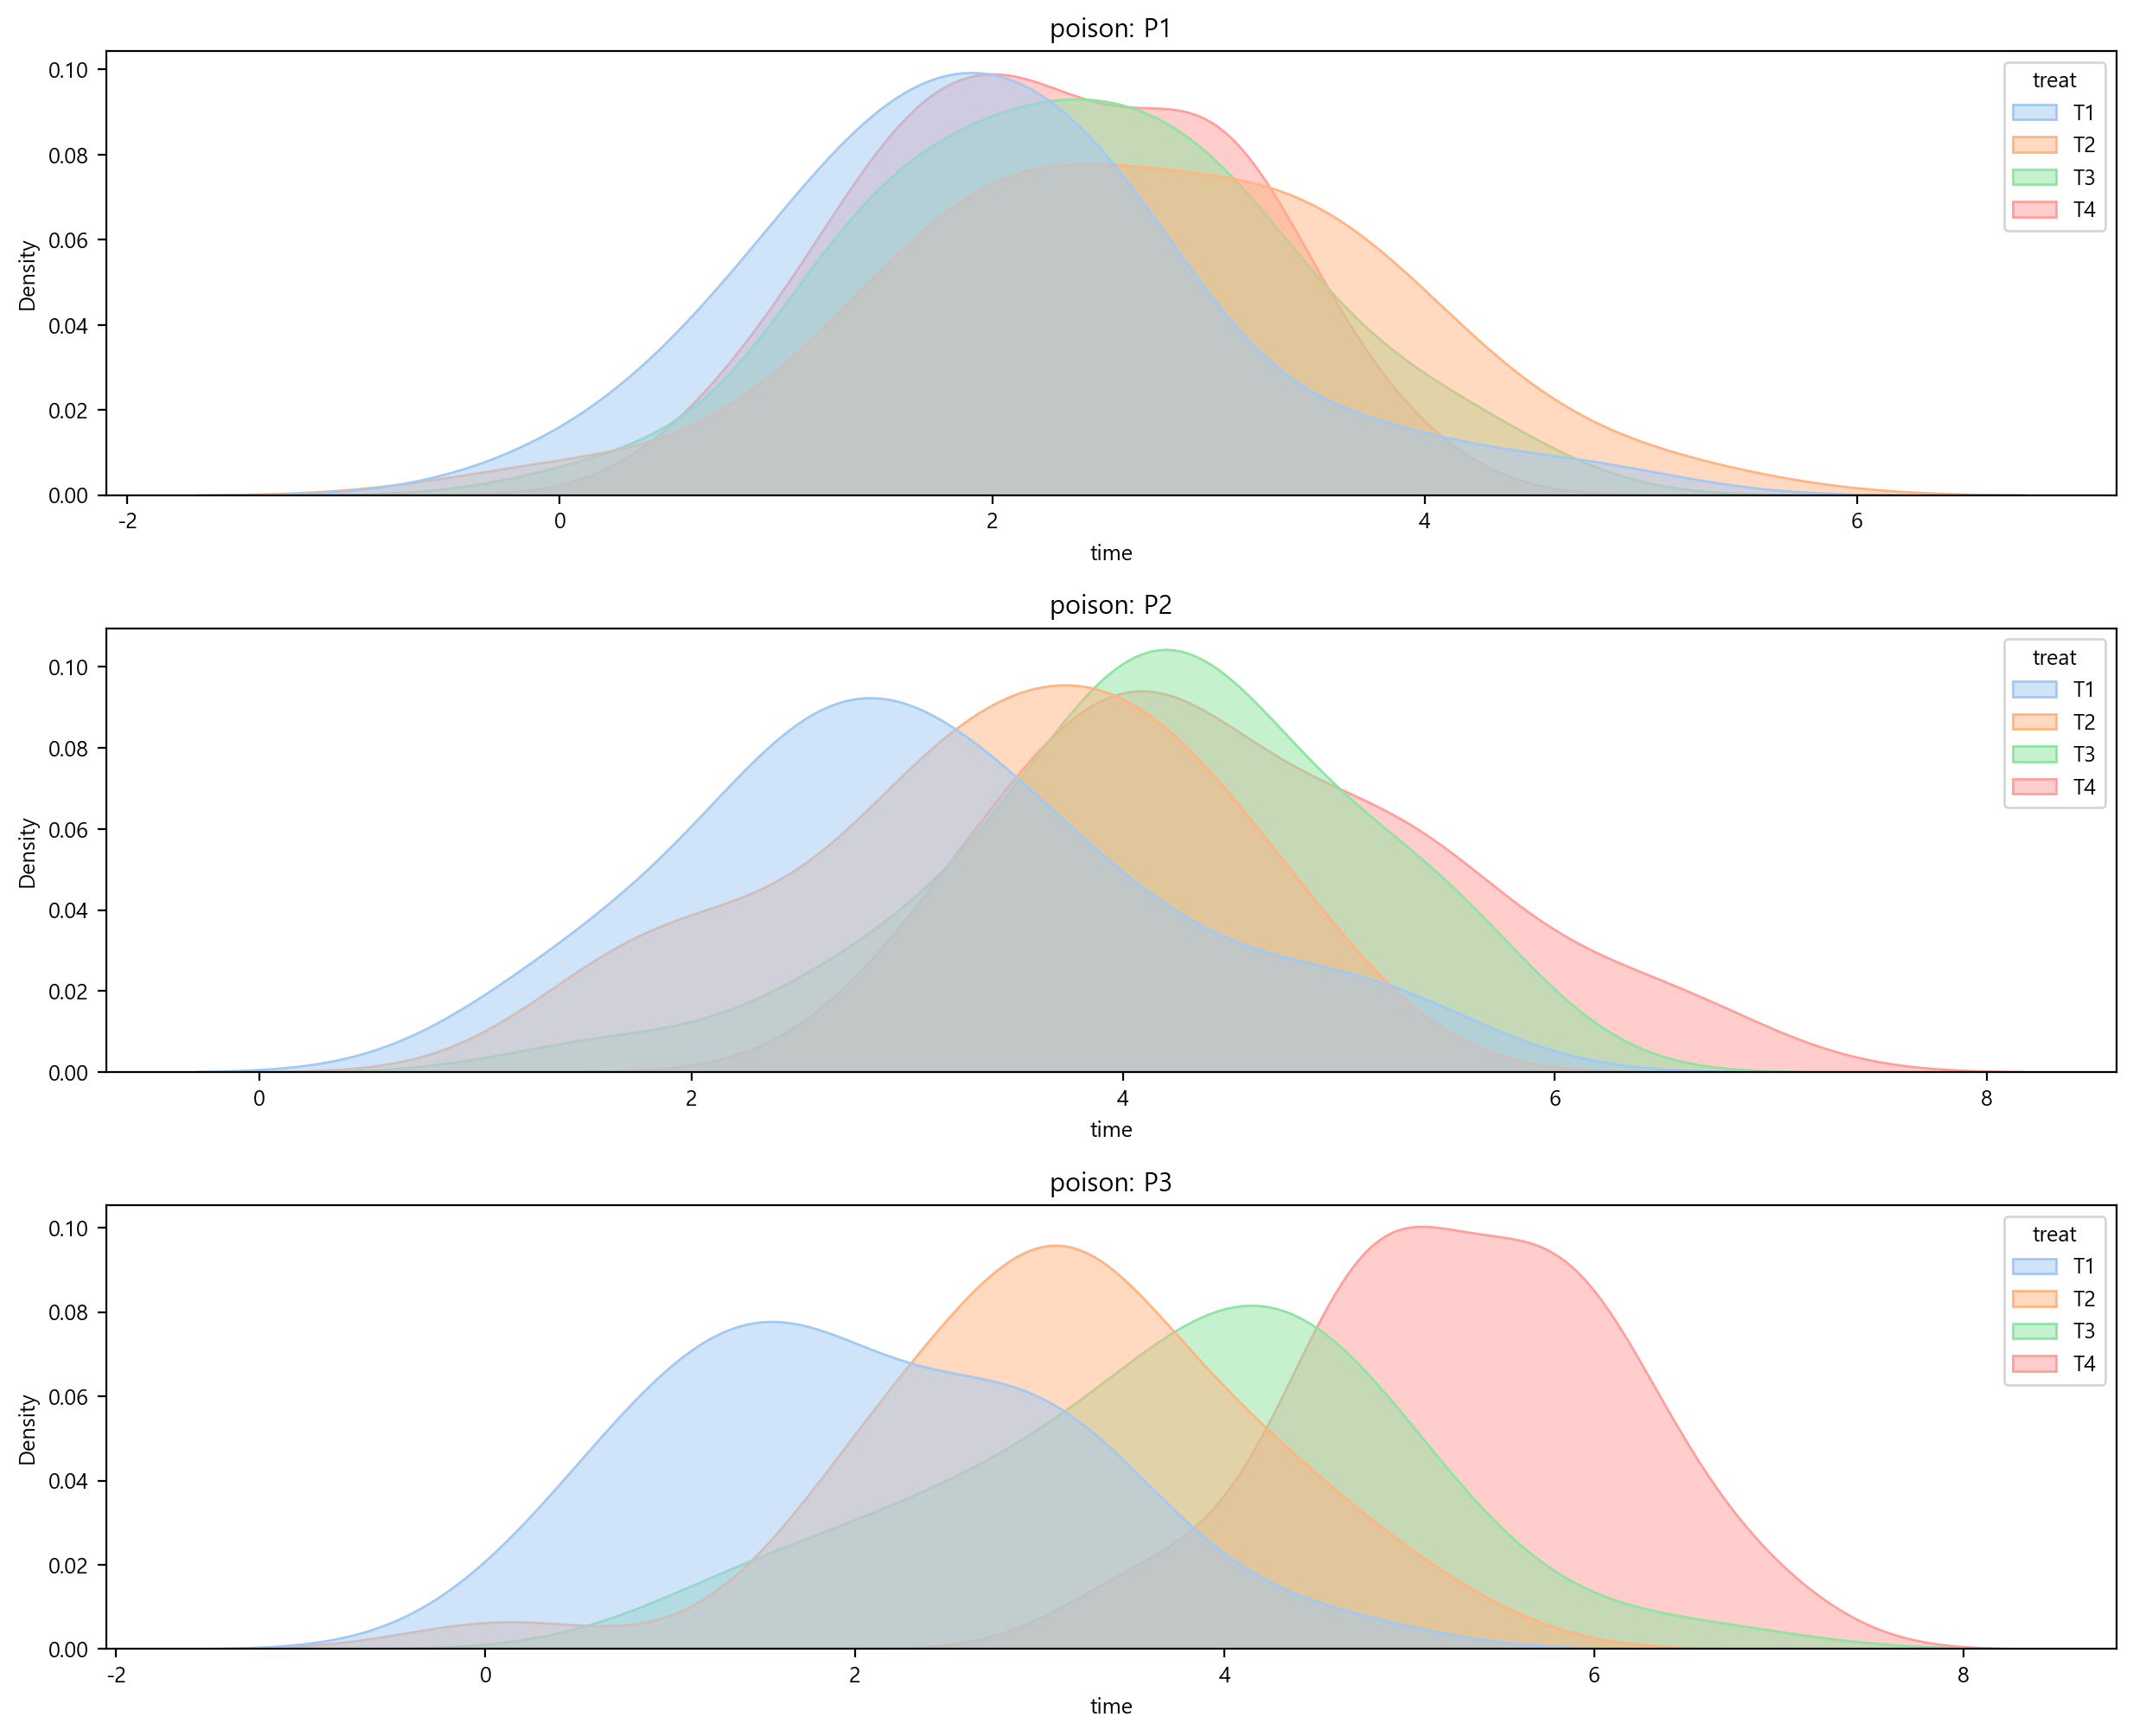

In [12]:
size = len(poison)
fig, ax = plt.subplots(size, 1, figsize=(15, 4*size))

fig.subplots_adjust(hspace=0.3)

for i, p in enumerate(poison):
    sb.kdeplot(data=origin[origin['poison'] == p], x='time', hue='treat',
               fill=True, alpha=0.5, palette='pastel', ax=ax[i])
    ax[i].set_title("poison: %s" % p)

plt.show()
plt.close()

> 같은 독극물이라도 치료 방법에 따라 생존시간에 차이를 보이는 것 같지만, 명확한 판별은 어렵다.

#### (2) 치료 유형에 따른 독극물 종류별 생존시간

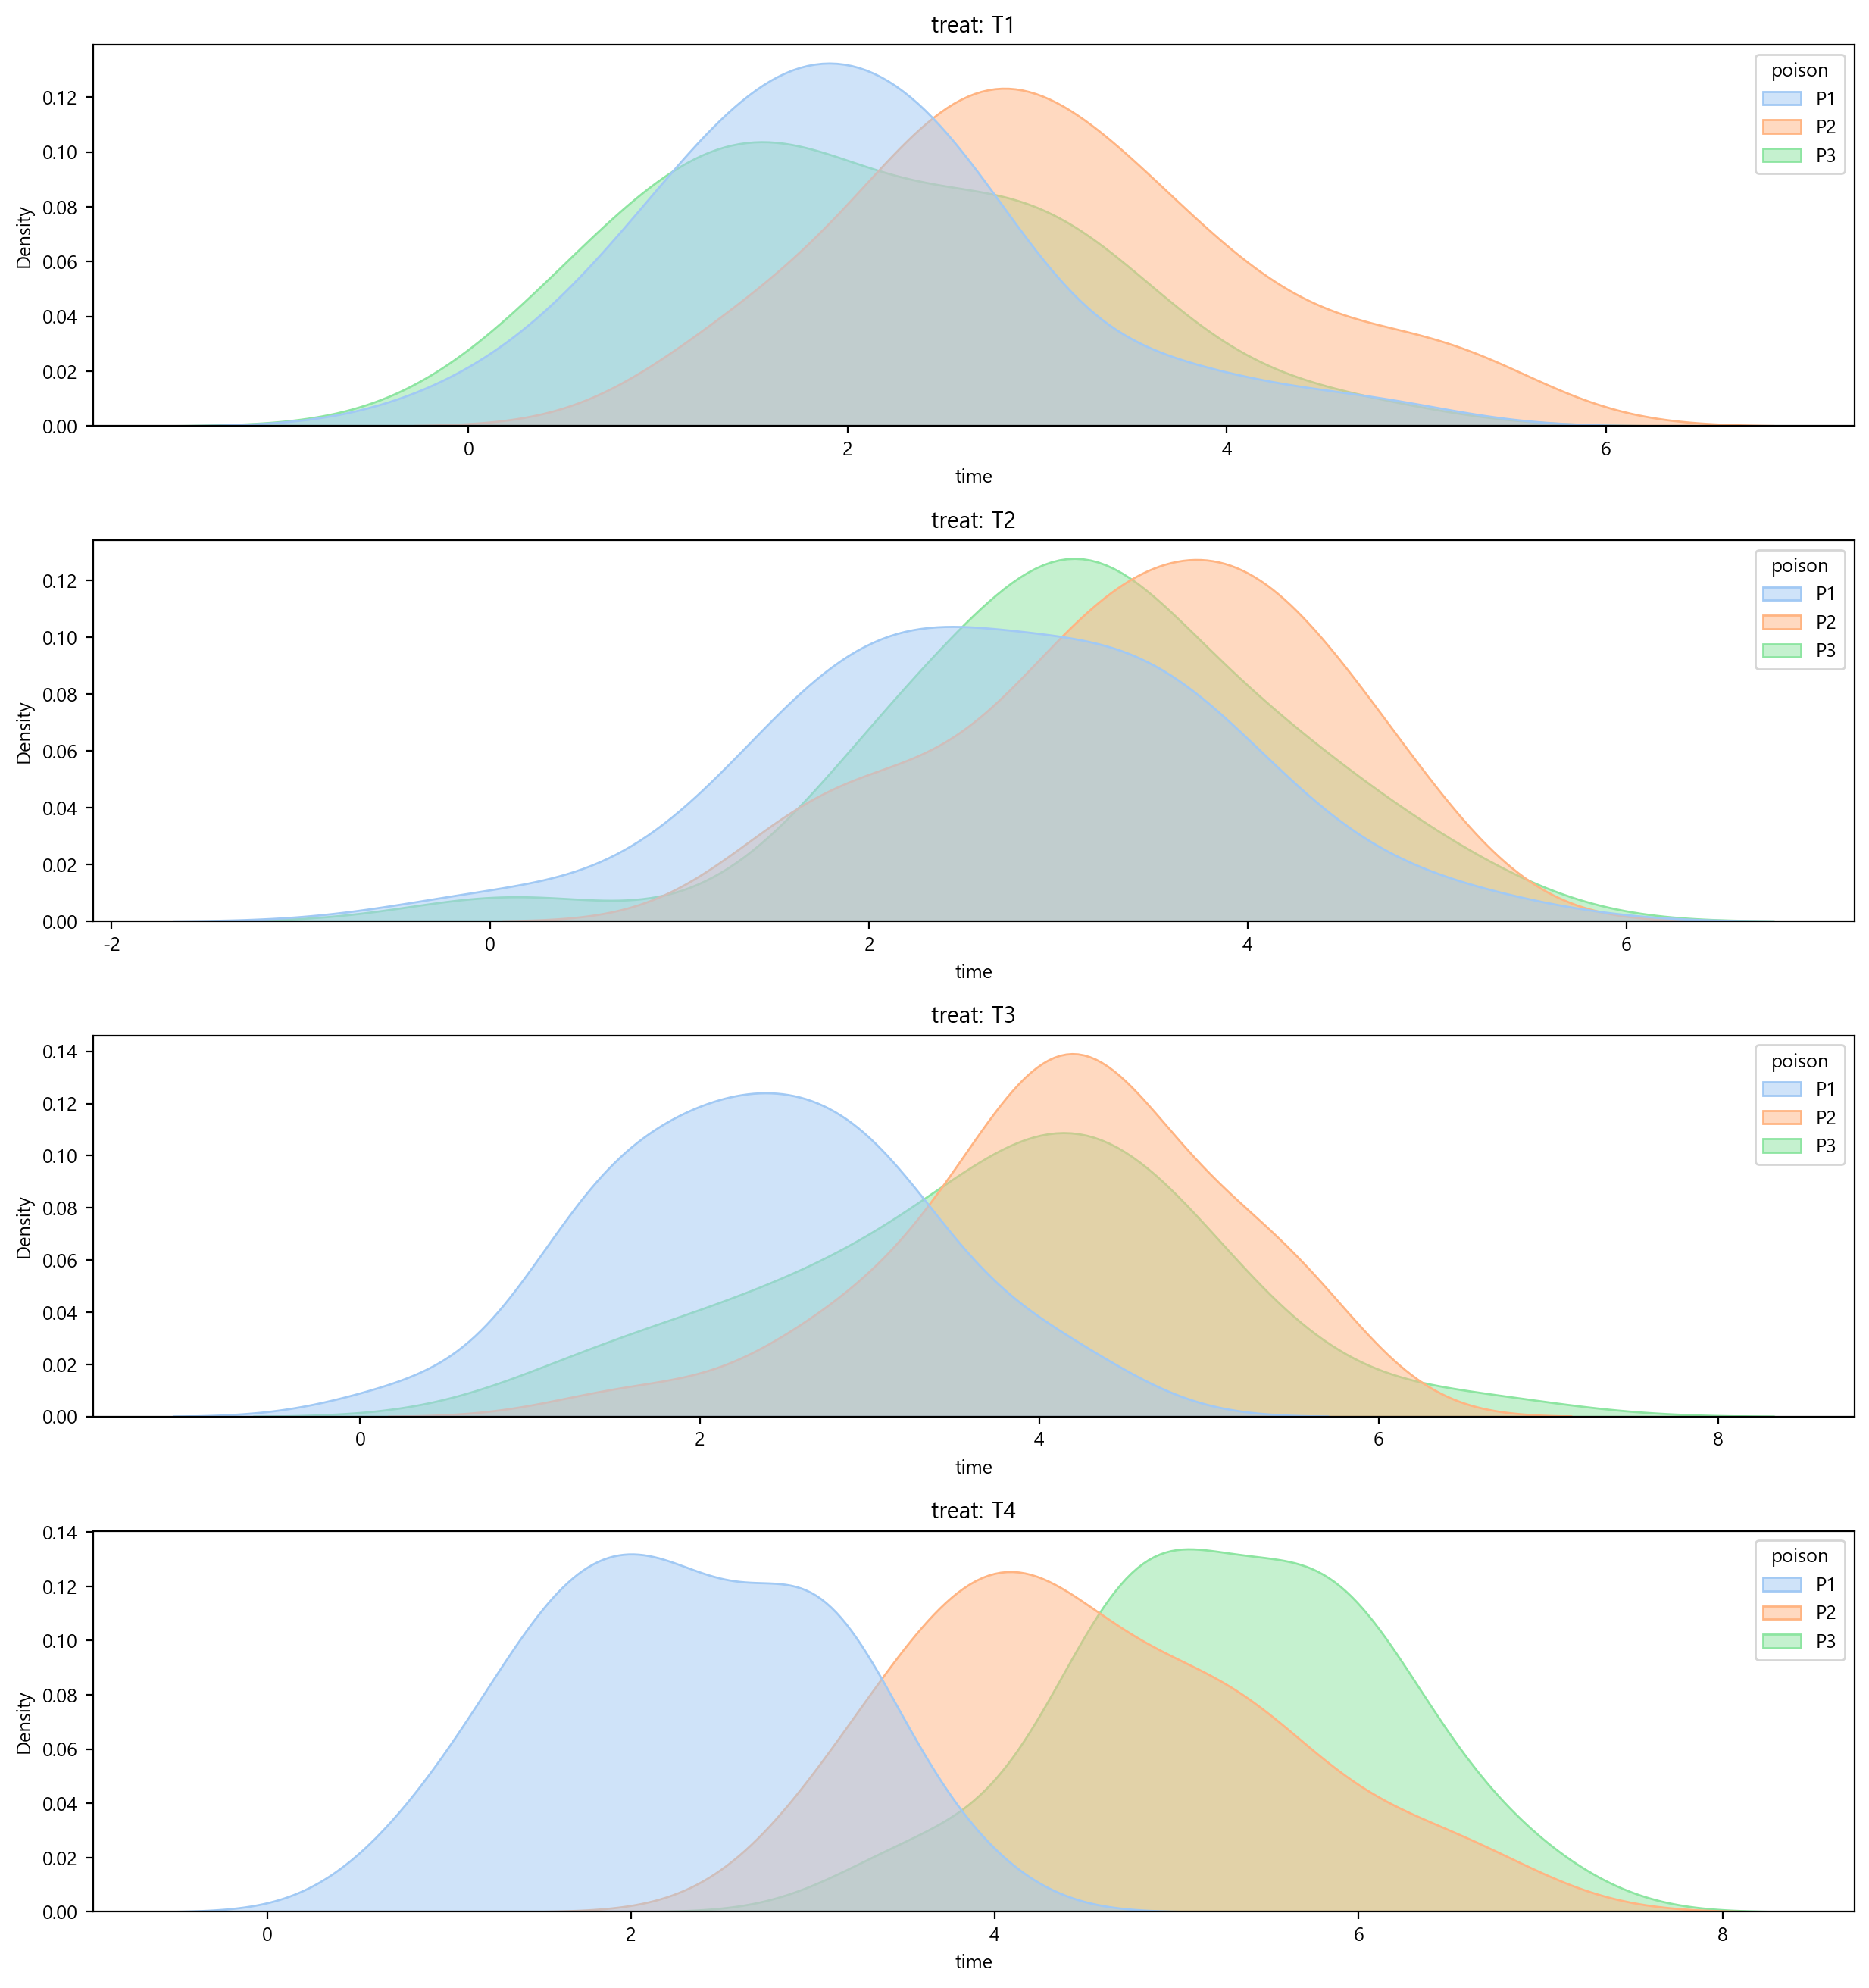

In [13]:
treat = origin['treat'].unique()
size = len(treat)

fig, ax = plt.subplots(size, 1, figsize=(15, 4*size))
fig.subplots_adjust(hspace=0.3)

for i, t in enumerate(treat):
    sb.kdeplot(data=origin[origin['treat'] == t], x='time', hue='poison',
               fill=True, alpha=0.5, palette='pastel', ax=ax[i])
    ax[i].set_title("treat: %s" % t)

plt.show()
plt.close()

> T1, T2, T3에서는 P2에 대한 생존시간이 가장 길었지만, T4에서는 P3에 대한 생존시간이 긴것으로 보인다.

### [3] 정규성, 등분산성 확인

In [14]:
data = origin.copy()
xname = ['poison', 'treat']
yname = 'time'

equal_var_fields = []
normal_dist = True
report = []

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({
            "field": "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"P1, T1",3.660816,0.160348,True
"P1, T2",0.266462,0.875263,True
"P1, T3",0.014374,0.992839,True
"P1, T4",1.476194,0.478023,True
"P2, T1",1.112279,0.573418,True
"P2, T2",1.509951,0.470022,True
"P2, T3",2.802084,0.246340,True
"P2, T4",1.662054,0.435602,True
"P3, T1",0.837473,0.657878,True


In [ ]:
data = origin.copy()
xname = ['$1', '$2']
yname = '$3'

equal_var_fields = []
normal_dist = True
report = []

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({
            "field": "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
})

report_df = DataFrame(report).set_index('field')
report_df

### [4] 분산분석

#### (1) statsmodels 패키지

In [15]:
lm = ols('time ~ C(poison)*C(treat)', origin).fit()
anova_result = anova_lm(lm, typ=2)
anova_result

,sum_sq,df,F,PR(>F)
C(poison),148.976389,2.0,74.722166,1.002877e-27
C(treat),131.260972,3.0,43.891090,4.430485e-24
C(poison):C(treat),81.381611,6.0,13.606206,6.938981e-14
Residual,346.910333,348.0,NaN,NaN


> 독극물 종류에 따른 생존시간은 통계적으로 유의미한 차이를 보인다($P \leq 0.05$)
>
> 치료방법에 따른 생존시간도 통계적으로 유의미한 차이를 보인다($P \leq 0.05$)
>
> 독극물 종류와 치료방법에는 교효작용이 있는 것으로 보인다.($P \leq 0.05$)

#### (2) pingouin 패키지

In [16]:
anova(data=origin, dv='time', between=['poison', 'treat'])

,Source,SS,DF,MS,F,p-unc,np2
0,poison,148.976389,2,74.488194,74.722166,1.002877e-27,0.300424
1,treat,131.260972,3,43.753657,43.891090,4.430485e-24,0.274506
2,poison * treat,81.381611,6,13.563602,13.606206,6.938981e-14,0.190014
3,Residual,346.910333,348,0.996869,NaN,NaN,NaN


### [5] 사후분석

이원분산분석의 경우 조합되는 경우의 수가 워낙 많기 때문에 교효작용의 존재 여부까지 확인하고 구체적인 비교를 위한 사후분석은 잘 수행하지 않는다.

아래는 이원 분산분석에 대한 사후검정 코드 예시임.

In [17]:
cate = origin[['poison', 'treat']].astype('category').agg('/'.join, axis=1)
cate

0      P1/T1
1      P1/T1
2      P1/T1
3      P1/T1
4      P1/T1
       ...  
355    P3/T4
356    P3/T4
357    P3/T4
358    P3/T4
359    P3/T4
Length: 360, dtype: object

In [18]:
tukey_results = pairwise_tukeyhsd(origin['time'], cate)
tukey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
P1/T1,P1/T2,0.69,0.2425,-0.1583,1.5383,False
P1/T1,P1/T3,0.39,0.9364,-0.4583,1.2383,False
P1/T1,P1/T4,0.3,0.9912,-0.5483,1.1483,False
P1/T1,P2/T1,1.09,0.0018,0.2417,1.9383,True
P1/T1,P2/T2,1.4533,0.0,0.6051,2.3016,True
P1/T1,P2/T3,2.1633,0.0,1.3151,3.0116,True
P1/T1,P2/T4,2.5567,0.0,1.7084,3.4049,True
P1/T1,P3/T1,0.06,1.0,-0.7883,0.9083,False
P1/T1,P3/T2,1.1433,0.0007,0.2951,1.9916,True
P1/T1,P3/T3,1.77,0.0,0.9217,2.6183,True


## 문제 3

### [1] 데이터 가져오기

In [19]:
origin = read_excel("https://data.hossam.kr/mldata/tomato.xlsx")
origin

,효소함량,모종성장
0,0,9.5
1,0,10.0
2,0,10.7
3,0,9.0
4,0,12.4
...,...,...
85,1000,15.8
86,1000,14.5
87,1000,13.5
88,1000,15.0


### [2] 데이터 분포 확인

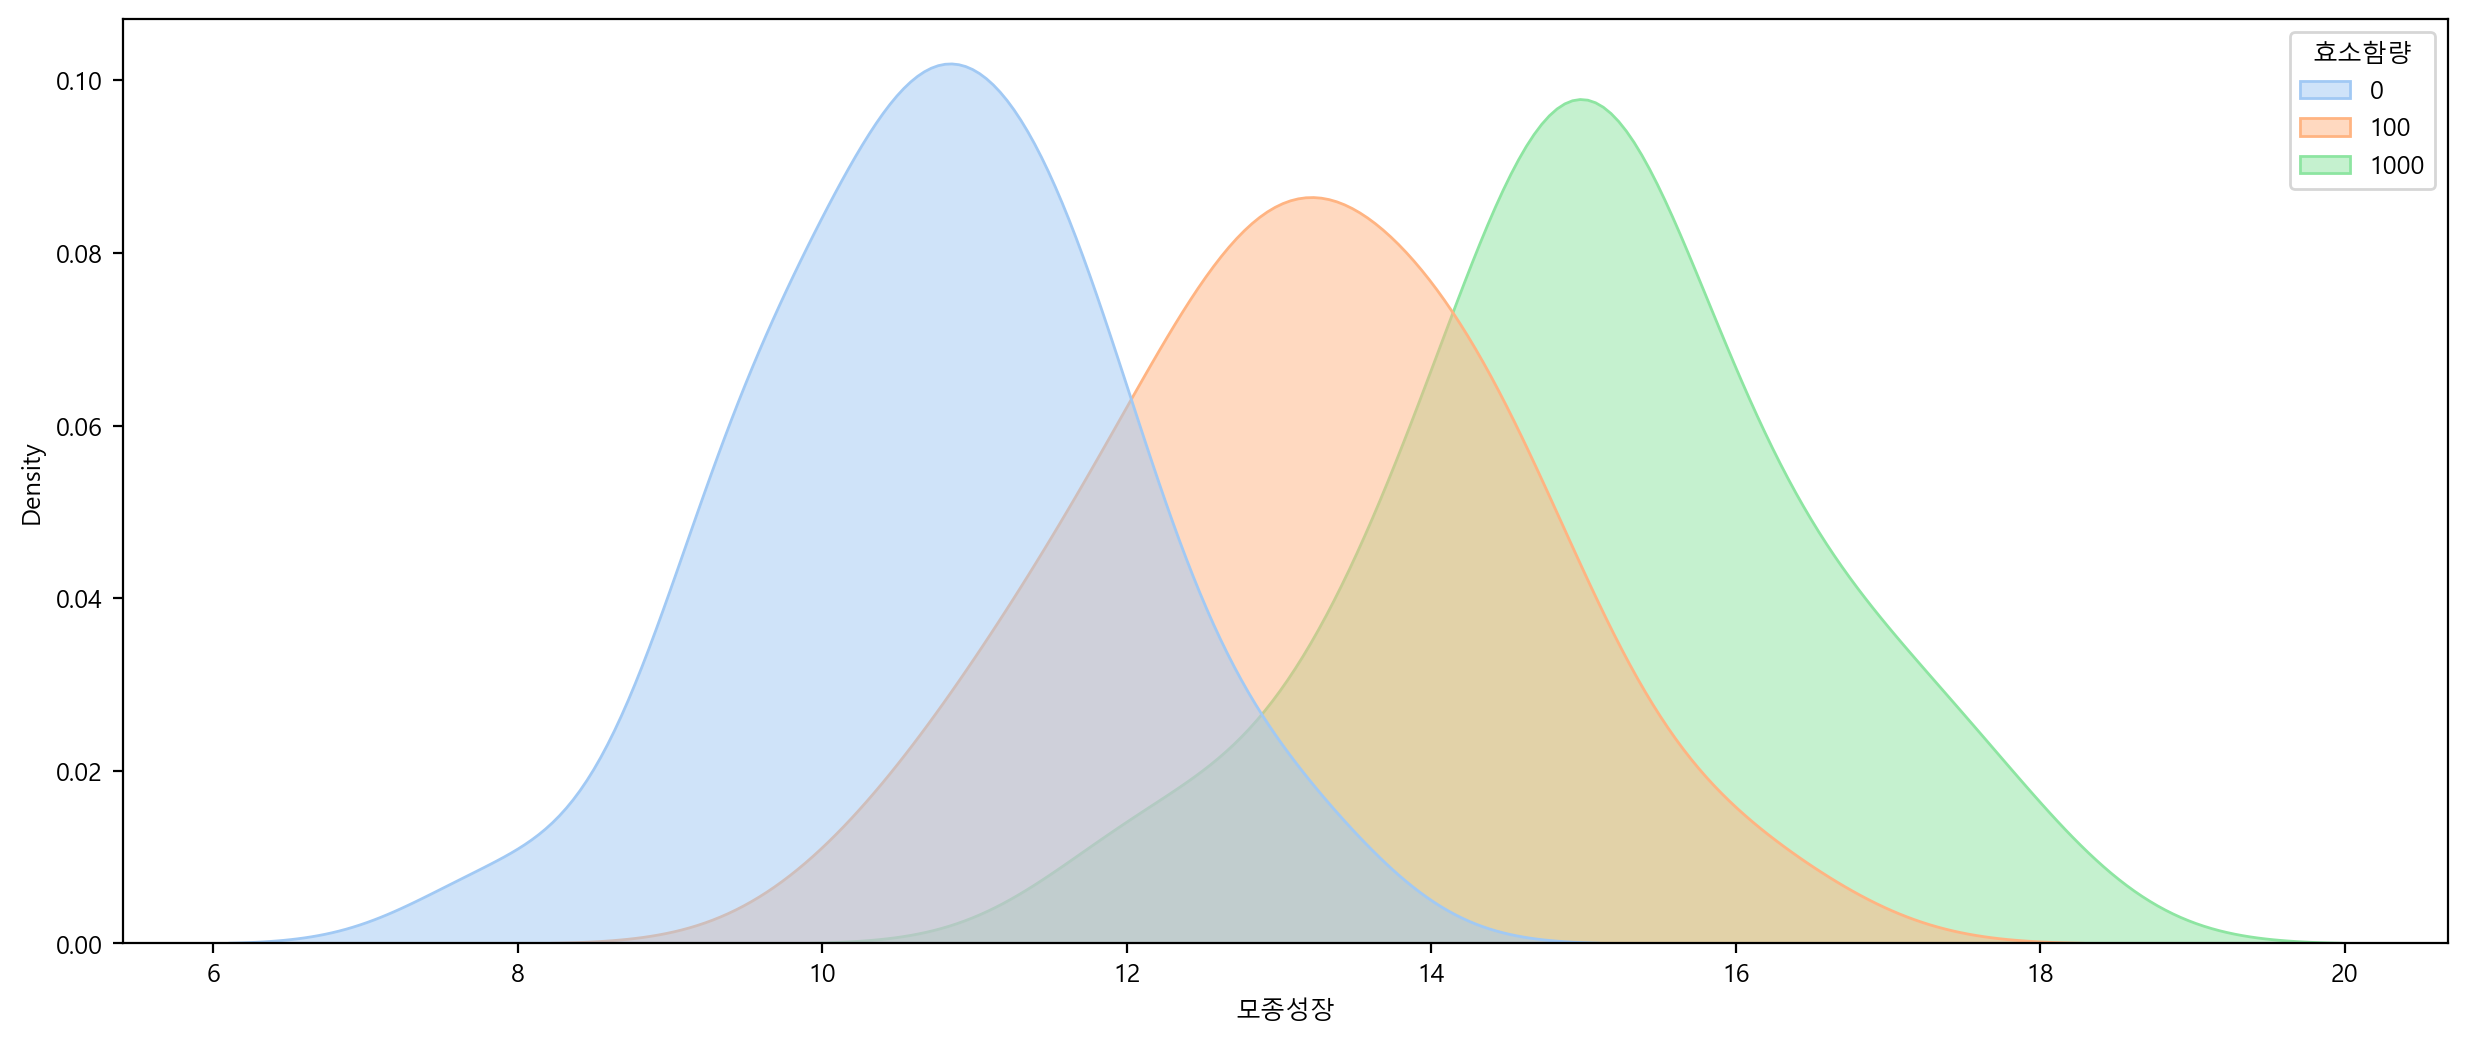

In [20]:
plt.figure()

sb.kdeplot(data=origin, x='모종성장', hue='효소함량',
           fill=True, alpha=0.5, palette='pastel')

plt.show()
plt.close()

> 효소 함량에 따라 모종 성장 분포가 다른것으로 확인된다.

### [3] 정규성, 등분산성 확인

In [21]:
data = origin.copy()
xname = '효소함량'
yname = '모종성장'

u1 = data[xname].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    filtered_data = data[data[xname] == i][yname]
    equal_var_fields.append(filtered_data)
    s, p = normaltest(filtered_data)

    normalize = p > 0.05
    report.append({"field": i, "statistic": s, "p-value": p, "result": normalize})
    normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

report.append({"field": n, "statistic": s, "p-value": p, "result": p > 0.05})
report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
0,0.237689,0.887946,True
100,0.000368,0.999816,True
1000,0.234748,0.889253,True
Bartlett,0.776052,0.678395,True


### [4] 분산분석 수행

#### (1) statsmodels 패키지 사용

In [22]:
lm = ols('모종성장 ~ C(효소함량)', data=origin).fit()
anova_result = anova_lm(lm)
s = anova_result['F'][0]
p = anova_result['PR(>F)'][0]
print("[anova_lm] statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무"))
anova_result

[anova_lm] statistic: 81.094, p-value: 0.000, 대립가설 채택


,df,sum_sq,mean_sq,F,PR(>F)
C(효소함량),2.0,279.292667,139.646333,81.094169,1.318657e-20
Residual,87.0,149.816333,1.722027,NaN,NaN


> 효소함량에 따른 모종성장은 통계적으로 유의미한 차이가 있다.($P \leq 0.05$)

#### (2) pingouin 패키지 사용

In [23]:
anova(data=origin, dv='모종성장', between='효소함량')

,Source,ddof1,ddof2,F,p-unc,np2
0,효소함량,2,87,81.094169,1.318657e-20,0.650866


### [5] 사후검정

#### (1) statsmodels 패키지

In [24]:
tukey = pairwise_tukeyhsd(origin['모종성장'], origin['효소함량'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,100,2.4267,0.0,1.6187,3.2346,True
0,1000,4.3033,0.0,3.4954,5.1113,True
100,1000,1.8767,0.0,1.0687,2.6846,True


> 효소 함량에 따른 토마토의 성장은 전체적으로 차이가 있다. 효소의 함량이 많을 수록 토마토 성장이 훨씬 잘 이루어 진다.

#### (2) pingouin 패키지

In [25]:
pairwise_tukey(data=origin, dv='모종성장', between='효소함량')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,0,100,10.753333,13.180000,-2.426667,0.338824,-7.162024,7.228520e-10,-1.867526
1,0,1000,10.753333,15.056667,-4.303333,0.338824,-12.700788,2.220446e-15,-3.315507
2,100,1000,13.180000,15.056667,-1.876667,0.338824,-5.538763,9.517362e-07,-1.350914


## 문제 4

### [1] 데이터 가져오기

In [26]:
origin = read_excel("https://data.hossam.kr/mldata/reading.xlsx")
origin.head()

,독서방법,점수
0,B,7.7
1,B,1.5
2,B,4.3
3,B,5.4
4,B,4.3


### [2] 데이터 분포 확인

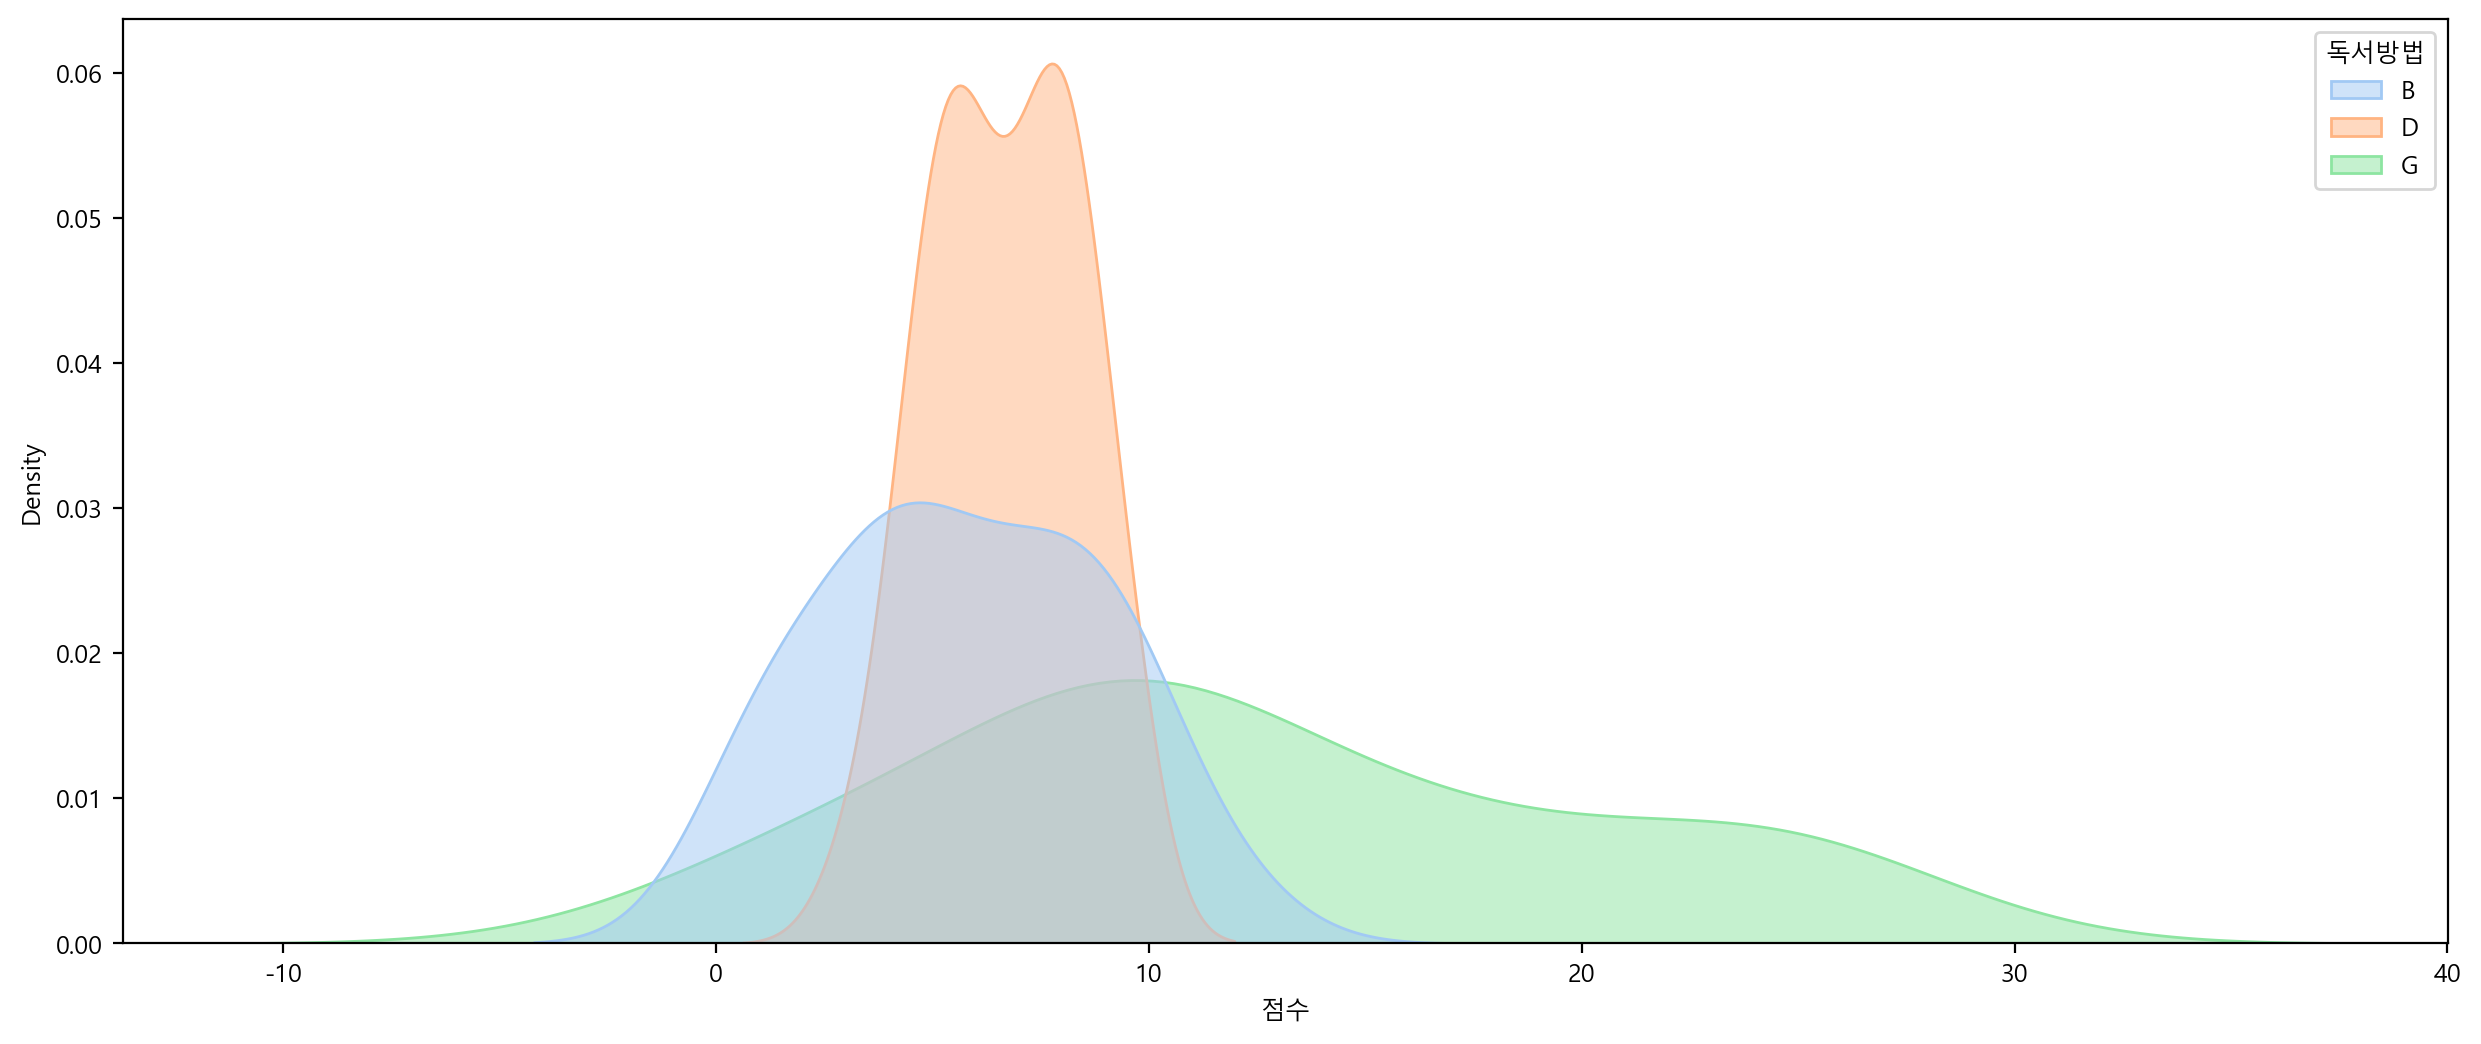

In [27]:
plt.figure()
sb.kdeplot(data=origin, x='점수', hue='독서방법', fill=True, alpha=0.5, palette='pastel')
plt.show()
plt.close()

### [3] 데이터 정규성, 등분산성 검정

In [28]:
data = origin.copy()
xname = '독서방법'
yname = '점수'

u1 = data[xname].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    filtered_data = data[data[xname] == i][yname]
    equal_var_fields.append(filtered_data)
    s, p = normaltest(filtered_data)

    normalize = p > 0.05
    report.append({"field": i, "statistic": s, "p-value": p, "result": normalize})
    normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

report.append({"field": n, "statistic": s, "p-value": p, "result": p > 0.05})
report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
B,2.210100,3.311943e-01,True
D,2.396634,3.017015e-01,True
G,2.216900,3.300701e-01,True
Bartlett,58.099241,2.420528e-13,False


### [4] 분산분석

등분산성을 충족하지 않으므로 웰치 검정을 수행해야 한다.

#### (1) statsmodels 패키지 사용

In [29]:
anova_oneway(origin['점수'],            # 종속변수
             groups=origin['독서방법'],  # 명목형 변수
             use_var ='unequal',        # 등분산 여부 (unequal, equal) / 기본값=unequal
             welch_correction =True     # 웰치검정 적용 여부 (True, False) / 기본값=True
            )

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 10.787454902442088
pvalue = 0.00013434653590208693
df = (2.0, 48.20412768831073)
df_num = 2.0
df_denom = 48.20412768831073
nobs_t = 90.0
n_groups = 3
means = array([ 5.73214286,  6.69333333, 12.53125   ])
nobs = array([28., 30., 32.])
vars_ = array([10.13115079,  2.87857471, 56.35770161])
use_var = 'unequal'
welch_correction = True
tuple = (10.787454902442088, 0.00013434653590208693)

#### (2) pingouin 패키지 사용

In [30]:
welch_anova(data=origin, dv='점수', between='독서방법')

,Source,ddof1,ddof2,F,p-unc,np2
0,독서방법,2,48.204128,10.787455,0.000134,0.283461


### [5] 사후검정

등분산성을 충족하지 않으므로 gameshowell 검정을 수행한다.

gameshowell 검정은 pingouin 패키지만 지원한다.

In [31]:
pairwise_gameshowell(data=origin, dv='점수', between='독서방법')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,B,D,5.732143,6.693333,-0.961190,0.676594,-1.420631,40.563109,0.339976,-0.375556
1,B,G,5.732143,12.531250,-6.799107,1.457054,-4.666340,42.964012,0.000088,-1.136960
2,D,G,6.693333,12.531250,-5.837917,1.362766,-4.283874,34.360873,0.000403,-1.043650


> B와 D간에는 독서점수의 차이가 없으나, B와 G, D와 G간에는 독서점수에 차이가 있다.

## 문제 5

### [1] 데이터 가져오기

In [32]:
origin = read_excel("https://data.hossam.kr/mldata/edu.xlsx")
origin.head()

,교육방법,국어,영어
0,1,65,82
1,1,87,79
2,1,73,85
3,1,79,60
4,1,81,65


### [2] 데이터 전처리

In [33]:
df = melt(origin, id_vars='교육방법', value_vars=['국어', '영어'], var_name='과목', value_name='점수')
df.head()

,교육방법,과목,점수
0,1,국어,65
1,1,국어,87
2,1,국어,73
3,1,국어,79
4,1,국어,81


### [3] 데이터 분포 확인

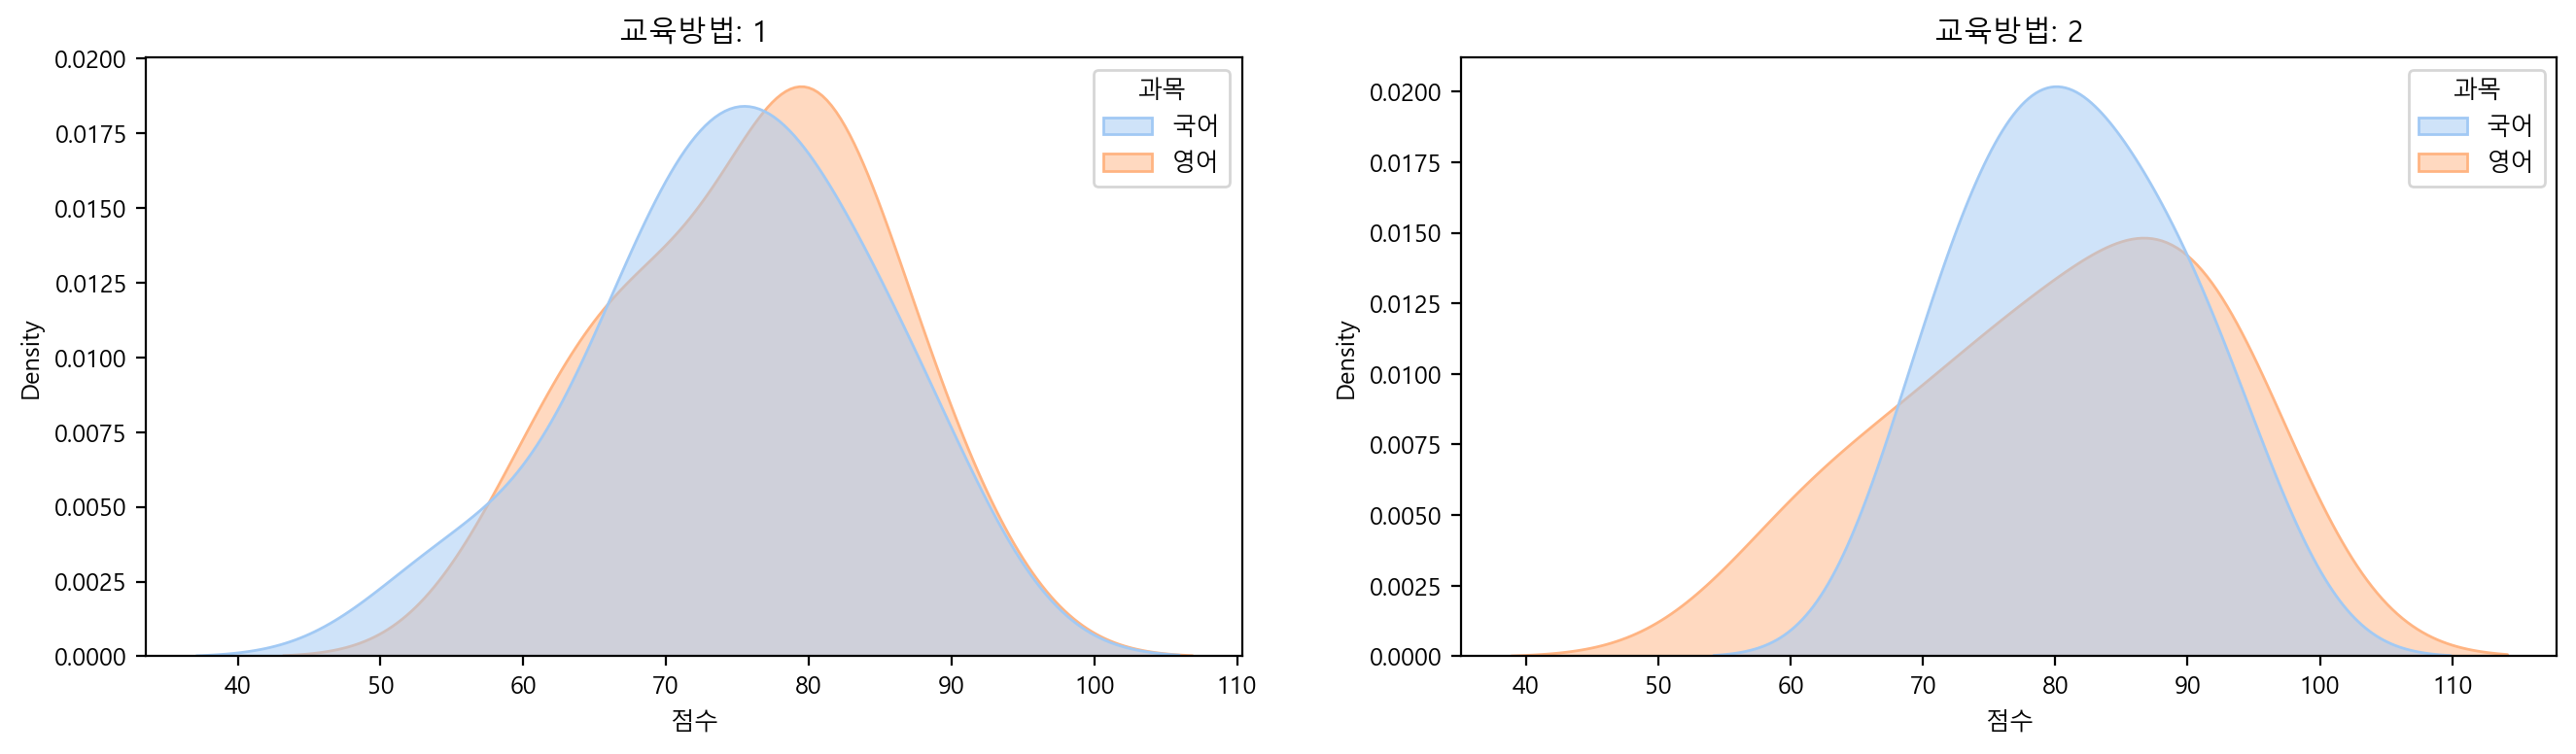

In [34]:
교육방법 = df['교육방법'].unique()
size = len(교육방법)

fig, ax = plt.subplots(1, size, figsize=(8*size, 4))

for i, t in enumerate(교육방법):
    sb.kdeplot(data=df[df['교육방법'] == t], x='점수', hue='과목',
               fill=True, alpha=0.5, palette='pastel', ax=ax[i])
    ax[i].set_title("교육방법: %s" % t)

plt.show()
plt.close()

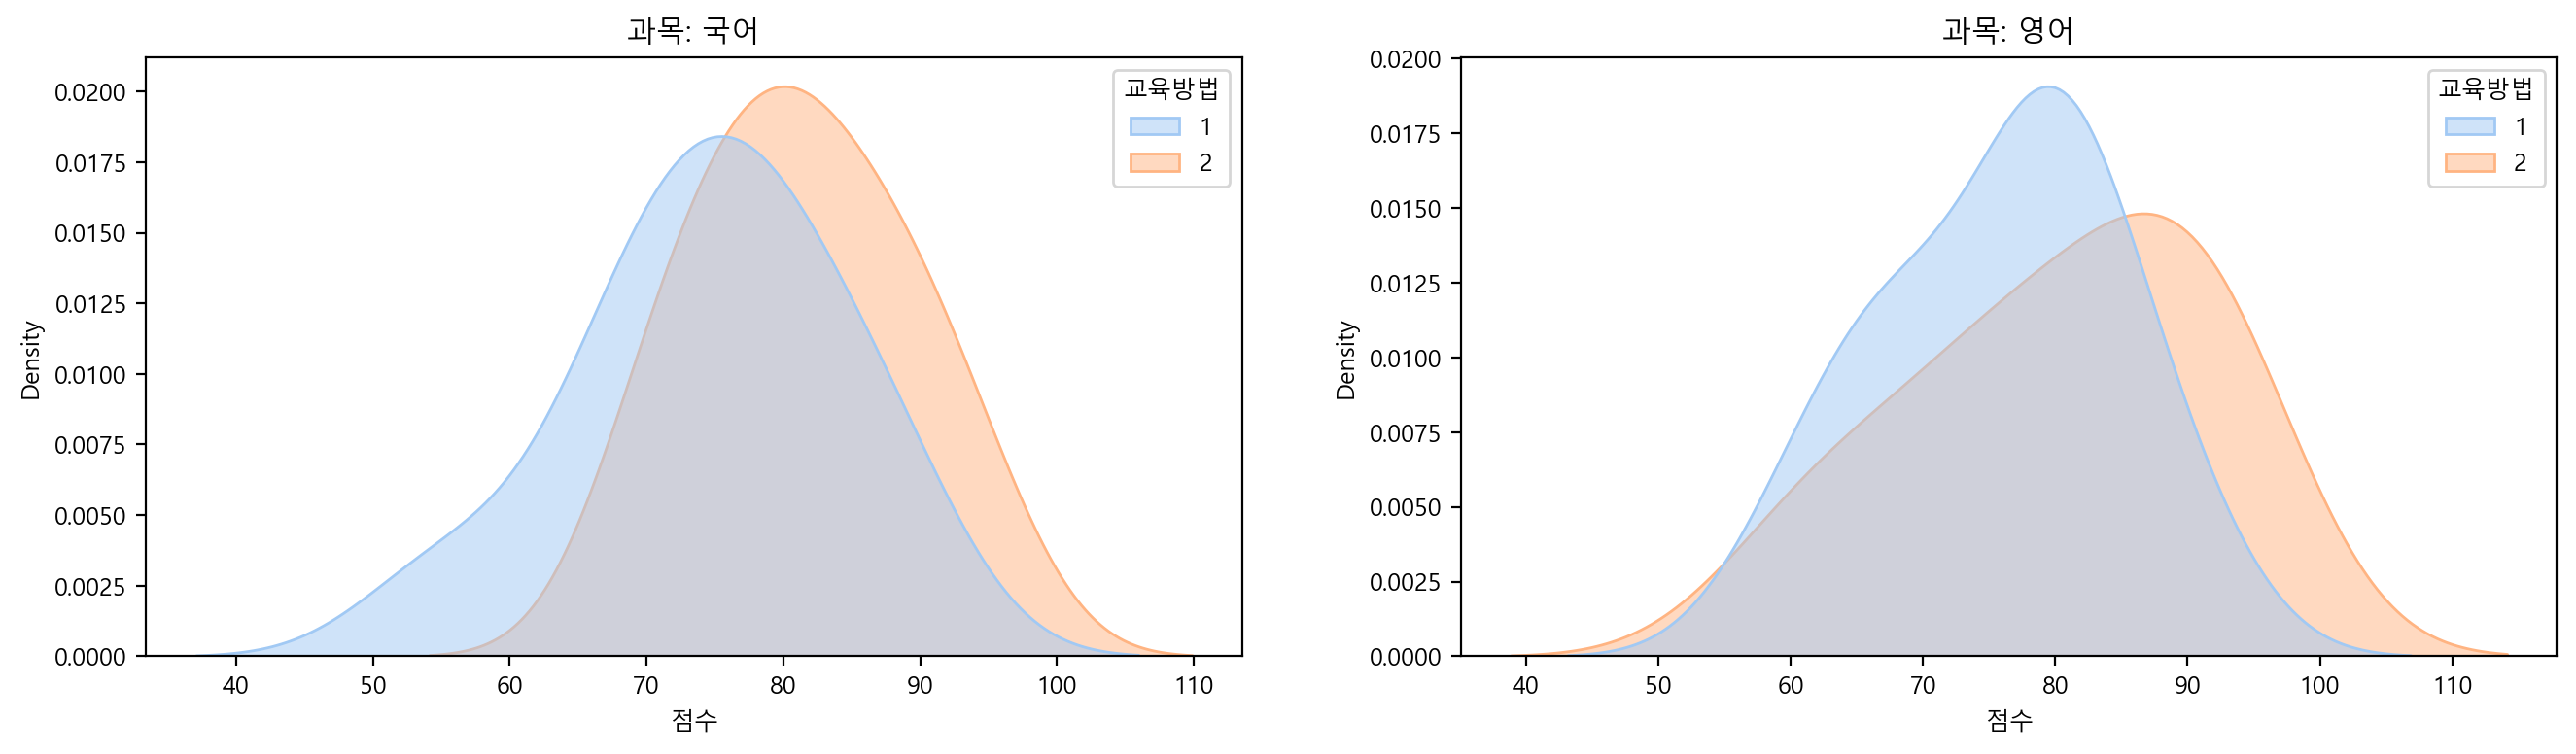

In [35]:
과목 = df['과목'].unique()
size = len(과목)

fig, ax = plt.subplots(1, size, figsize=(8*size, 4))

for i, t in enumerate(과목):
    sb.kdeplot(data=df[df['과목'] == t], x='점수', hue='교육방법',
               fill=True, alpha=0.5, palette='pastel', ax=ax[i])
    ax[i].set_title("과목: %s" % t)

plt.show()
plt.close()

### [4] 정규성, 등분산성 확인

In [36]:
data = df.copy()
xname = ['교육방법', '과목']
yname = '점수'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({"field": "{0}, {1}".format(i, j), "statistic": s, "p-value": p, "result": normalize})
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

report.append({"field": n, "statistic": s, "p-value": p, "result": p > 0.05})
report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"1, 국어",0.911351,0.634020,True
"1, 영어",0.389198,0.823165,True
"2, 국어",0.299661,0.860854,True
"2, 영어",1.094669,0.578490,True
Bartlett,1.252529,0.740435,True


### [4] 분산분석

#### (1) statsmodels 패키지 사용

In [37]:
lm = ols('점수 ~ C(교육방법)*C(과목)', df).fit()
anova_result = anova_lm(lm, typ=2)
anova_result

,sum_sq,df,F,PR(>F)
C(교육방법),355.113636,1.0,3.845870,0.056857
C(과목),0.204545,1.0,0.002215,0.962695
C(교육방법):C(과목),14.204545,1.0,0.153835,0.696979
Residual,3693.454545,40.0,NaN,NaN


> 교육방법에 따른 과목별 점수에는 통계적으로 유의한 차이를 보이지 않는다.($P > 0.05$)

#### (2) pingouin 패키지 사용

In [38]:
anova(data=df, dv='점수', between=['교육방법', '과목'])

,Source,SS,DF,MS,F,p-unc,np2
0,교육방법,355.113636,1,355.113636,3.845870,0.056857,0.087713
1,과목,0.204545,1,0.204545,0.002215,0.962695,0.000055
2,교육방법 * 과목,14.204545,1,14.204545,0.153835,0.696979,0.003831
3,Residual,3693.454545,40,92.336364,NaN,NaN,NaN


## 문제 6

### [1] 데이터 가져오기

In [39]:
origin = read_excel("https://data.hossam.kr/mldata/commercial.xlsx")
origin.head()

,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166


### [2] 상권 종류별 2023년 한 해 동안의 평균 매출액 차이

#### (1) 데이터 전처리

##### 필요한 변수만 추출

In [40]:
df1 = origin[['type', 'sales_amount']]
df1.head()

,type,sales_amount
0,관광특구,72523644100
1,관광특구,283332346393
2,관광특구,81696730221
3,관광특구,212062656625
4,관광특구,231338386876


##### 로그를 적용한 파생변수 생성

매출액의 단위가 너무 크므로 로그를 씌워서 스케일링 함

In [41]:
df1['sales_amount_log'] = np.log(df1['sales_amount'])
df1.head()

,type,sales_amount,sales_amount_log
0,관광특구,72523644100,25.007178
1,관광특구,283332346393,26.369886
2,관광특구,81696730221,25.126280
3,관광특구,212062656625,26.080148
4,관광특구,231338386876,26.167147


#### (2) 데이터 분포 확인

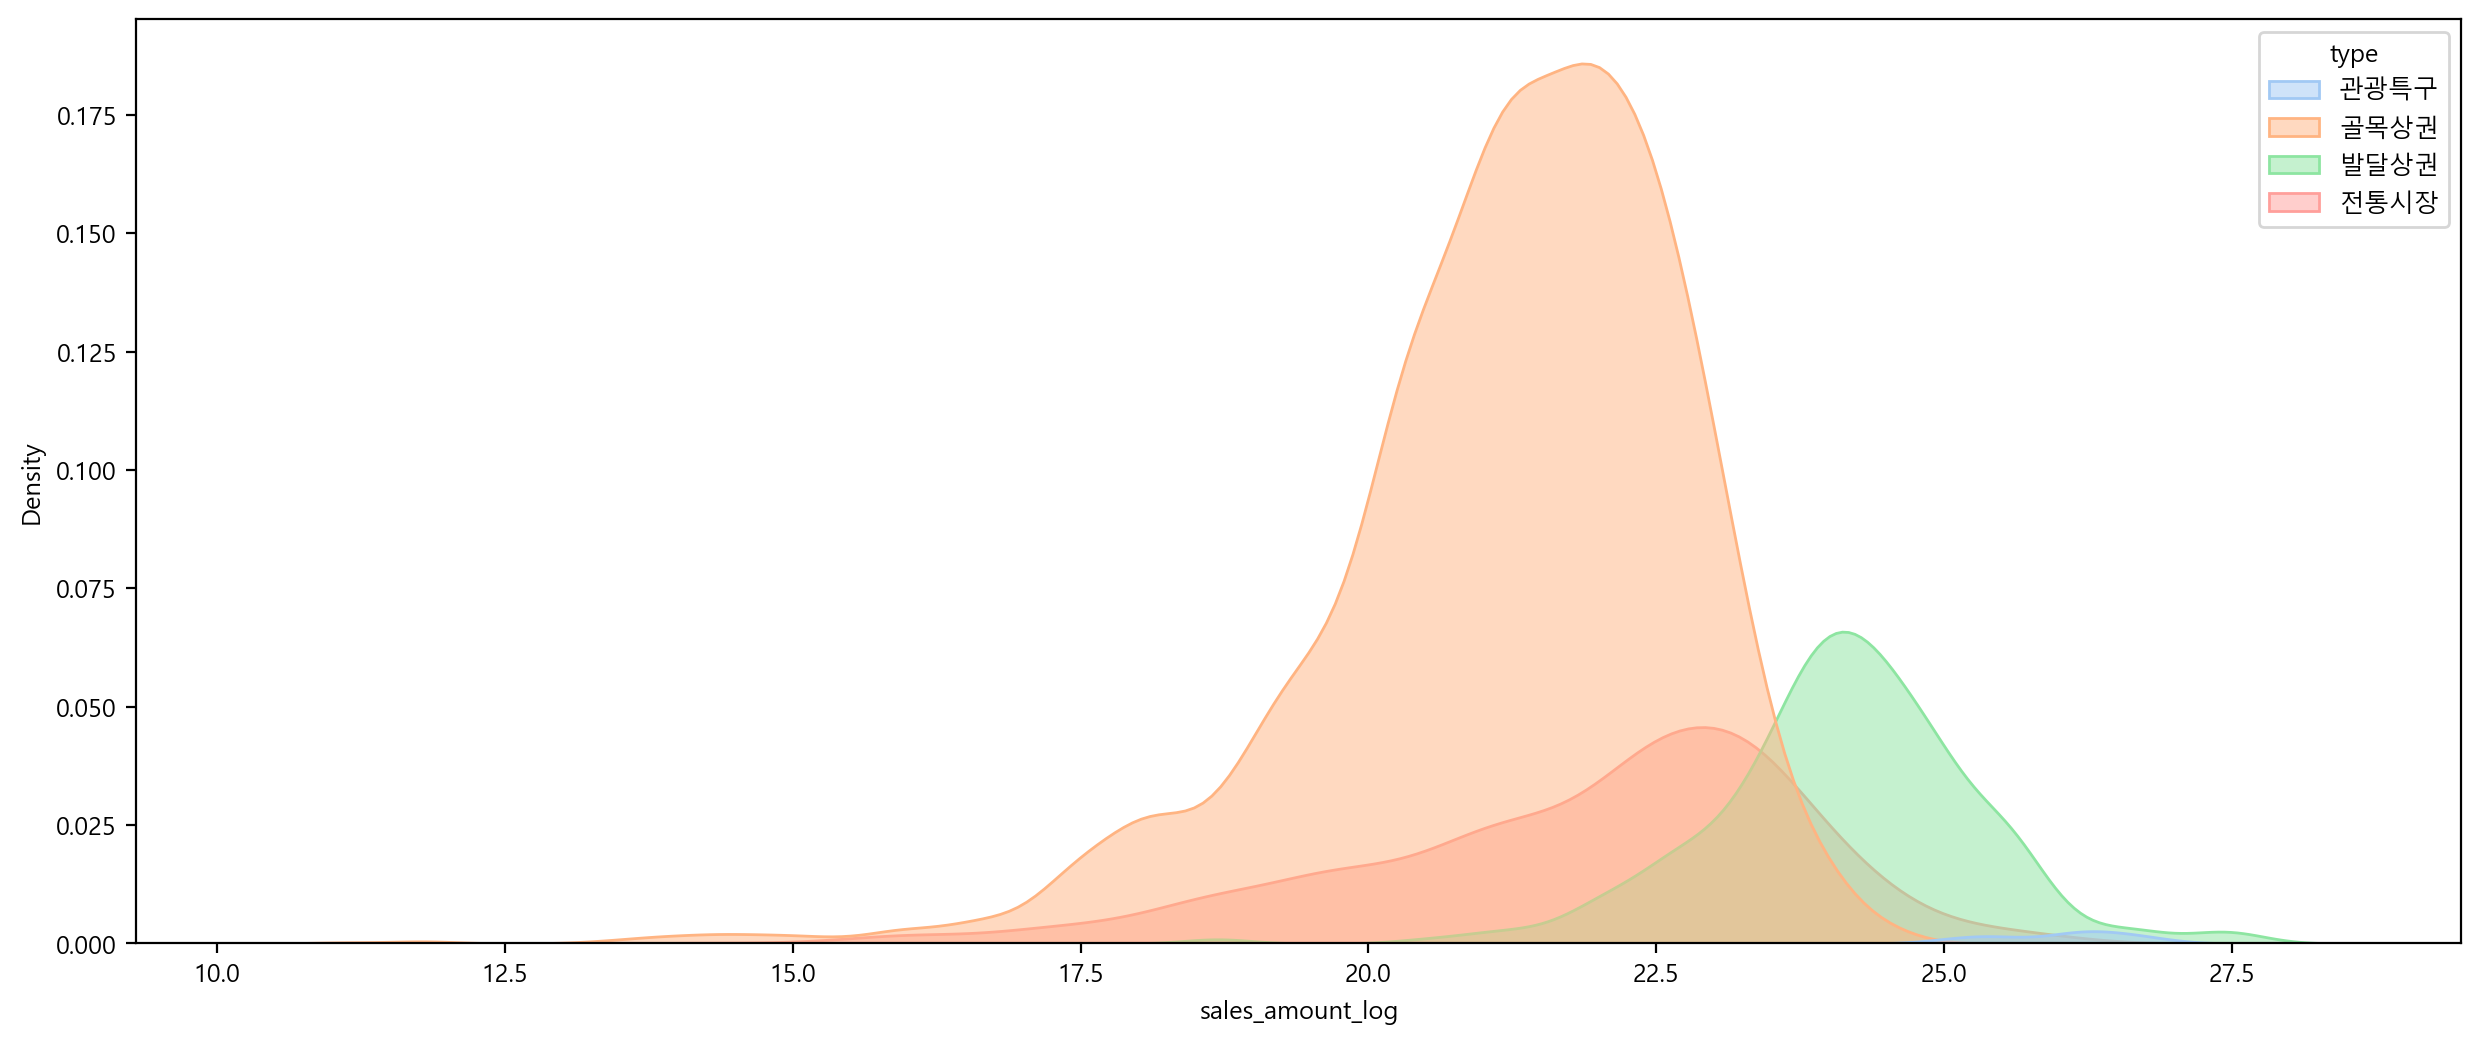

In [42]:
plt.figure()
sb.kdeplot(data=df1, x='sales_amount_log', hue='type', fill=True, alpha=0.5, palette='pastel')
plt.show()
plt.close()

#### (3) 정규성, 등분산성 확인

In [43]:
data = df1.copy()
xname = 'type'
yname = 'sales_amount_log'

u1 = data[xname].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    filtered_data = data[data[xname] == i][yname]
    equal_var_fields.append(filtered_data)
    s, p = normaltest(filtered_data)

    normalize = p > 0.05
    report.append({"field": i, "statistic": s, "p-value": p, "result": normalize})
    normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

report.append({"field": n, "statistic": s, "p-value": p, "result": p > 0.05})
report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
관광특구,3.776144,1.513634e-01,True
골목상권,850.892535,1.702290e-185,False
발달상권,84.529259,4.412701e-19,False
전통시장,100.318850,1.644518e-22,False
Levene,67.037354,1.173224e-42,False


> 등분산성 가정을 충족하지 않으므로 welch 검정을 통해 평균을 비교해야 한다.

#### (4) 분산분석

In [44]:
welch_anova(data=df1, dv='sales_amount_log', between='type')

,Source,ddof1,ddof2,F,p-unc,np2
0,type,3,117.954981,1842.976509,7.053276e-99,0.319485


> 상권 종류에 따른 일년간의 매출 평균액은 통계적으로 유의미한 차이를 보인다.($P \leq 0.05$)

#### (5) 사후검정

In [45]:
result = pairwise_gameshowell(df1, dv='sales_amount_log', between='type')
result['results'] = result['pval'] <= 0.05
result

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges,results
0,골목상권,관광특구,21.188783,26.018229,-4.829446,0.116139,-41.583473,25.192873,2.220446e-15,-3.087560,True
1,골목상권,발달상권,21.188783,24.111665,-2.922882,0.044081,-66.306856,1987.319203,0.000000e+00,-1.953267,True
2,골목상권,전통시장,21.188783,21.846978,-0.658194,0.062833,-10.475263,1527.837271,0.000000e+00,-0.398660,True
3,관광특구,발달상권,26.018229,24.111665,1.906565,0.119291,15.982446,28.035019,1.121325e-14,1.661959,True
4,관광특구,전통시장,26.018229,21.846978,4.171252,0.127418,32.736855,36.449092,0.000000e+00,2.183914,True
5,발달상권,전통시장,24.111665,21.846978,2.264687,0.068485,33.068280,1844.617220,0.000000e+00,1.407066,True


### [3] 분기에 따른 상권 종류별 평균 매출 비교

#### (1) 데이터 전처리

##### 필요한 데이터 추출

In [46]:
df2 = origin[['quarter', 'type', 'sales_amount']]
df2.head()

,quarter,type,sales_amount
0,1,관광특구,72523644100
1,1,관광특구,283332346393
2,1,관광특구,81696730221
3,1,관광특구,212062656625
4,1,관광특구,231338386876


##### 매출액 로그 변환

In [47]:
df2['sales_amount_log'] = np.log(df1['sales_amount'])
df2.head()

,quarter,type,sales_amount,sales_amount_log
0,1,관광특구,72523644100,25.007178
1,1,관광특구,283332346393,26.369886
2,1,관광특구,81696730221,25.126280
3,1,관광특구,212062656625,26.080148
4,1,관광특구,231338386876,26.167147


#### (2) 데이터 분포 확인

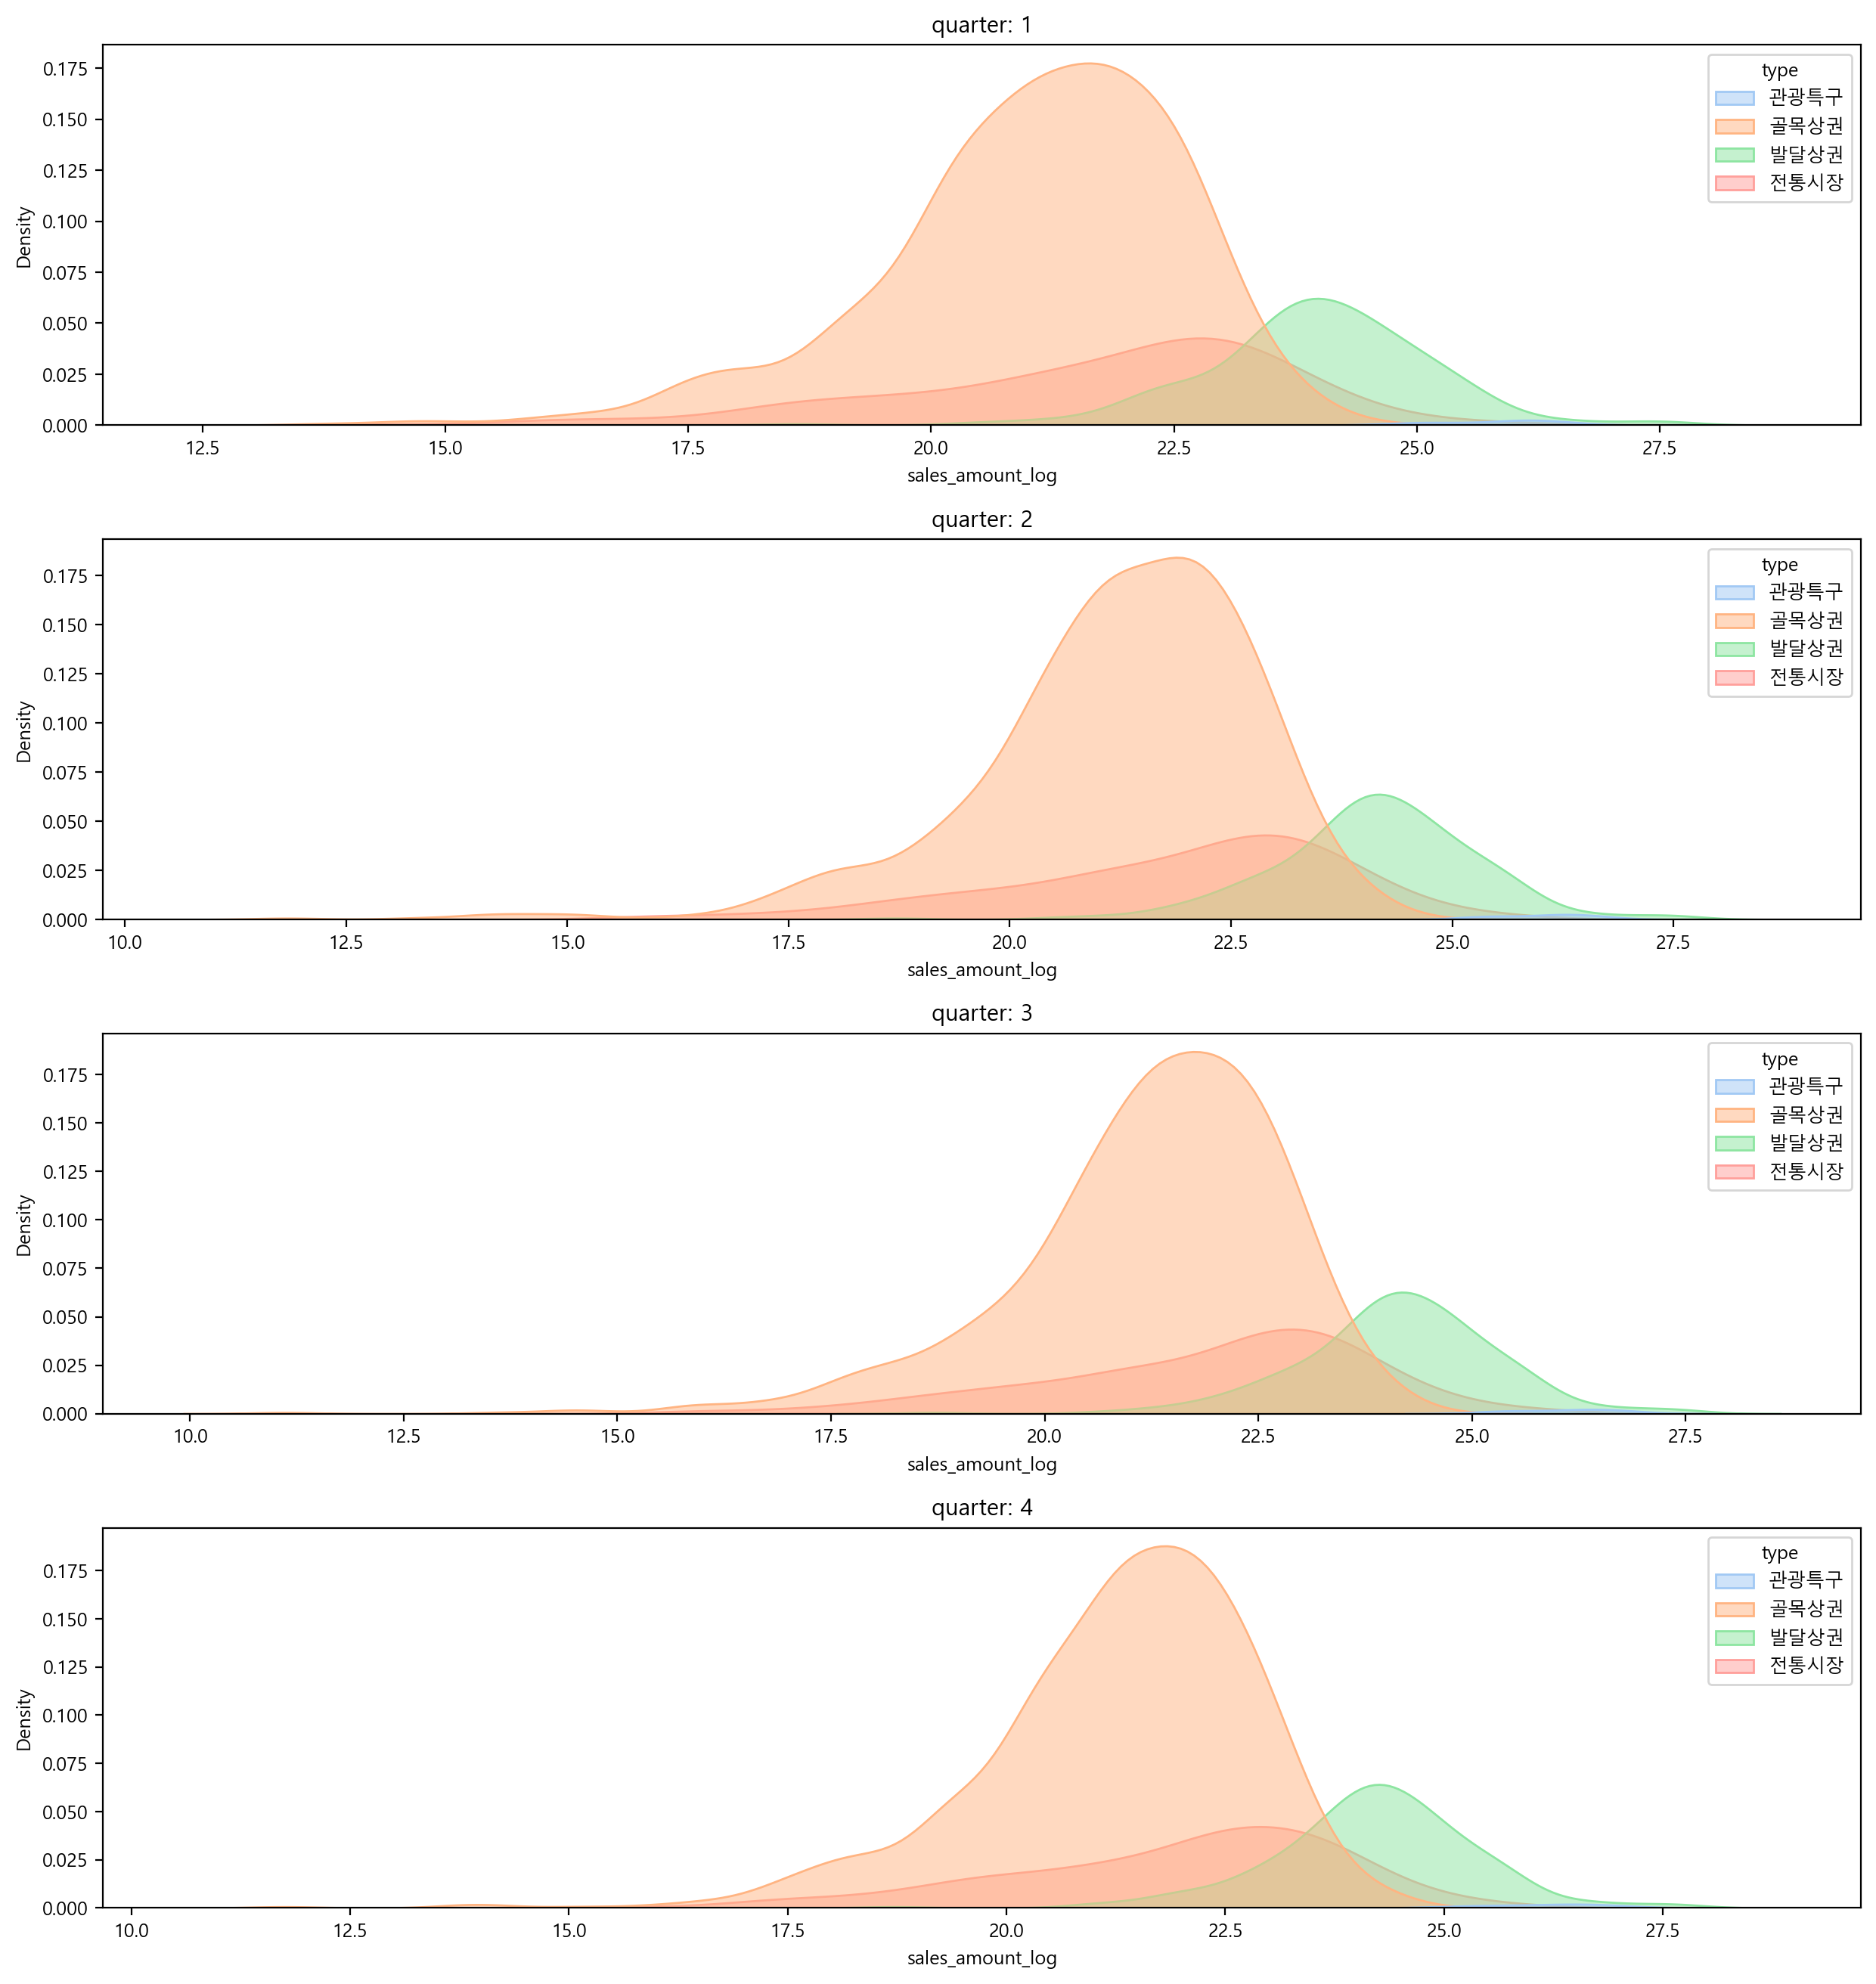

In [48]:
quarter = df2['quarter'].unique()
size = len(quarter)

fig, ax = plt.subplots(size, 1, figsize=(15, 4*size))
fig.subplots_adjust(hspace=0.3)

for i, q in enumerate(quarter):
    sb.kdeplot(data=df2[df2['quarter'] == q], x='sales_amount_log', hue='type',
               fill=True, alpha=0.5, palette='pastel', ax=ax[i])
    ax[i].set_title("quarter: %s" % q)

plt.show()
plt.close()

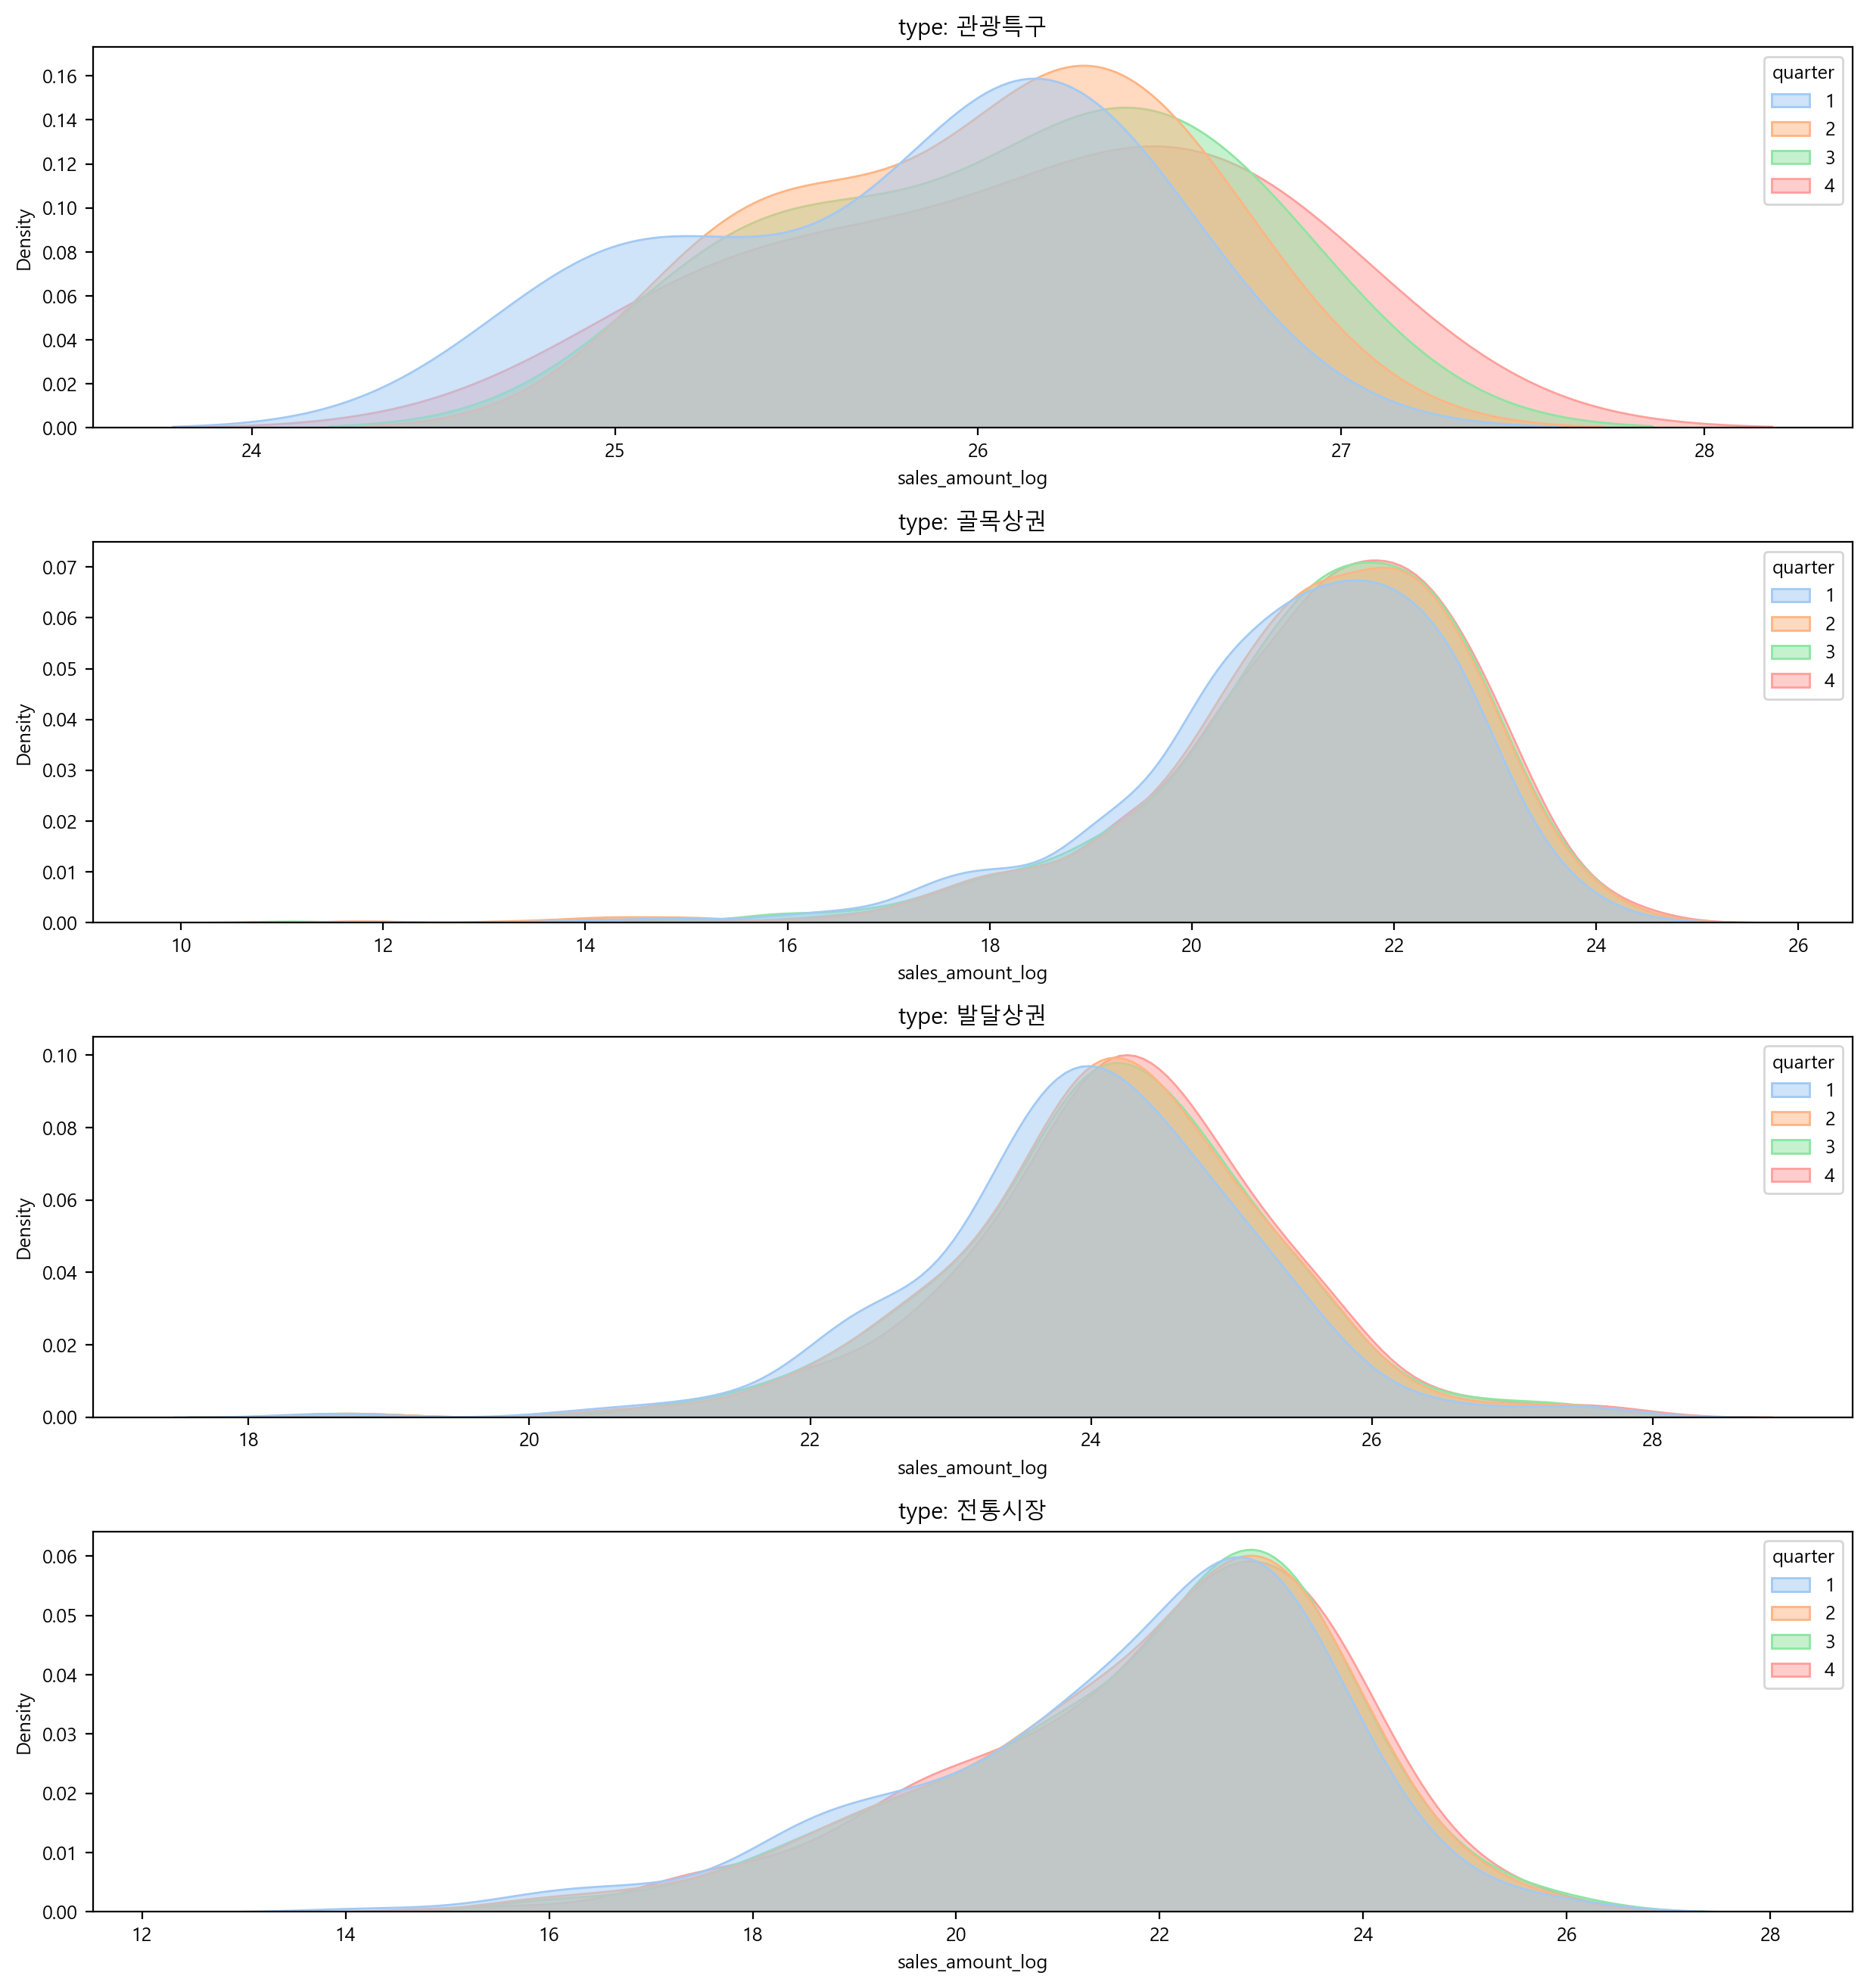

In [49]:
type = df2['type'].unique()
size = len(type)

fig, ax = plt.subplots(size, 1, figsize=(15, 4*size))
fig.subplots_adjust(hspace=0.3)

for i, t in enumerate(type):
    sb.kdeplot(data=df2[df2['type'] == t], x='sales_amount_log', hue='quarter',
               fill=True, alpha=0.5, palette='pastel', ax=ax[i])
    ax[i].set_title("type: %s" % t)

plt.show()
plt.close()

#### (3) 데이터 정규성, 등분산성 확인

In [50]:
data = df2.copy()
xname = ['quarter', 'type']
yname = 'sales_amount_log'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        if len(filtered_data) < 8:
            continue
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({"field": "{0}, {1}".format(i, j), "statistic": s, "p-value": p, "result": normalize})
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

report.append({"field": n, "statistic": s, "p-value": p, "result": p > 0.05})
report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"1, 골목상권",144.141897,5.011695e-32,False
"1, 발달상권",22.394075,1.371476e-05,False
"1, 전통시장",32.539741,8.591818e-08,False
"2, 골목상권",263.522084,5.982829e-58,False
"2, 발달상권",26.110636,2.138688e-06,False
"2, 전통시장",25.992622,2.268683e-06,False
"3, 골목상권",246.282869,3.314016e-54,False
"3, 발달상권",24.464916,4.869798e-06,False
"3, 전통시장",22.359476,1.395409e-05,False


#### (4) 이원분산분석

In [51]:
lm = ols('sales_amount_log ~ C(quarter)*C(type)', data=df2).fit()
anova_result = anova_lm(lm, typ=2)
s = anova_result['F'][0]
p = anova_result['PR(>F)'][0]
print("[anova_lm] statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무"))
anova_result

[anova_lm] statistic: 6.683, p-value: 0.000, 대립가설 채택


,sum_sq,df,F,PR(>F)
C(quarter),49.935651,3.0,6.682753,0.000168
C(type),7280.936898,3.0,974.388118,0.000000
C(quarter):C(type),0.426489,9.0,0.019025,1.000000
Residual,15457.733100,6206.0,NaN,NaN
